#### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

from tqdm import tqdm
import os

In [ ]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA
from scipy.stats import levene, ttest_ind

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Aish_celltypeRNN/Dales-backprop')

Mounted at /content/drive


In [ ]:
from data_loader import makeTensorLoaders

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#### Test for CUDA

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Model and related hyper-params

In [ ]:
nRuns = 5

In [ ]:
batch_size = 200 ##100

In [ ]:
latent_scaling = 16
pop_list_types = [12,2,1]

In [ ]:
n_areas = 2
n_depths = 3

## Number of recurrent neurons in total
N = int(n_areas*n_depths*np.sum(pop_list_types)*latent_scaling)

#### Data for nRuns

In [ ]:
default_path = '/content/drive/MyDrive/Aish_celltypeRNN/data-processing/averaged_familiar_change/train_test/'

suffix = 'familiar_change'

In [ ]:
# Loading fitting data
dff_V1_L4_sst_train = np.load(default_path + 'dff_V1_L4_sst_' + suffix + '_train.npy')
dff_V1_L23_sst_train = np.load(default_path +'dff_V1_L23_sst_' + suffix + '_train.npy')
dff_V1_L5_sst_train = np.load(default_path +'dff_V1_L5_sst_' + suffix + '_train.npy')

dff_V1_L4_vip_train = np.load(default_path +'dff_V1_L4_vip_' + suffix + '_train.npy')
dff_V1_L23_vip_train = np.load(default_path +'dff_V1_L23_vip_' + suffix + '_train.npy')
dff_V1_L5_vip_train = np.load(default_path +'dff_V1_L5_vip_' + suffix + '_train.npy')

dff_V1_L4_pyr_train = np.load(default_path +'dff_V1_L4_pyr_' + suffix + '_train.npy')
dff_V1_L23_pyr_train = np.load(default_path +'dff_V1_L23_pyr_' + suffix + '_train.npy')
dff_V1_L5_pyr_train = np.load(default_path +'dff_V1_L5_pyr_' + suffix + '_train.npy')

dff_LM_L4_sst_train = np.load(default_path +'dff_LM_L4_sst_' + suffix + '_train.npy')
dff_LM_L23_sst_train = np.load(default_path +'dff_LM_L23_sst_' + suffix + '_train.npy')
dff_LM_L5_sst_train = np.load(default_path +'dff_LM_L5_sst_' + suffix + '_train.npy')

dff_LM_L4_vip_train = np.load(default_path +'dff_LM_L4_vip_' + suffix + '_train.npy')
dff_LM_L23_vip_train = np.load(default_path +'dff_LM_L23_vip_' + suffix + '_train.npy')
dff_LM_L5_vip_train = np.load(default_path +'dff_LM_L5_vip_' + suffix + '_train.npy')

dff_LM_L4_pyr_train = np.load(default_path +'dff_LM_L4_pyr_' + suffix + '_train.npy')
dff_LM_L23_pyr_train = np.load(default_path +'dff_LM_L23_pyr_' + suffix + '_train.npy')
dff_LM_L5_pyr_train = np.load(default_path +'dff_LM_L5_pyr_' + suffix + '_train.npy')

# Loading predictive data
dff_V1_L4_pyr_test = np.load(default_path +'dff_V1_L4_pyr_' + suffix + '_test.npy')
dff_V1_L23_pyr_test = np.load(default_path +'dff_V1_L23_pyr_' + suffix + '_test.npy')
dff_V1_L5_pyr_test = np.load(default_path +'dff_V1_L5_pyr_' + suffix + '_test.npy')

dff_V1_L4_sst_test = np.load(default_path +'dff_V1_L4_sst_' + suffix + '_test.npy')
dff_V1_L23_sst_test = np.load(default_path +'dff_V1_L23_sst_' + suffix + '_test.npy')
dff_V1_L5_sst_test = np.load(default_path +'dff_V1_L5_sst_' + suffix + '_test.npy')

dff_V1_L4_vip_test = np.load(default_path +'dff_V1_L4_vip_' + suffix + '_test.npy')
dff_V1_L23_vip_test = np.load(default_path +'dff_V1_L23_vip_' + suffix + '_test.npy')
dff_V1_L5_vip_test = np.load(default_path +'dff_V1_L5_vip_' + suffix + '_test.npy')

dff_LM_L4_pyr_test = np.load(default_path +'dff_LM_L4_pyr_' + suffix + '_test.npy')
dff_LM_L23_pyr_test = np.load(default_path +'dff_LM_L23_pyr_' + suffix + '_test.npy')
dff_LM_L5_pyr_test = np.load(default_path +'dff_LM_L5_pyr_' + suffix + '_test.npy')

dff_LM_L4_sst_test = np.load(default_path +'dff_LM_L4_sst_' + suffix + '_test.npy')
dff_LM_L23_sst_test = np.load(default_path +'dff_LM_L23_sst_' + suffix + '_test.npy')
dff_LM_L5_sst_test = np.load(default_path +'dff_LM_L5_sst_' + suffix + '_test.npy')

dff_LM_L4_vip_test = np.load(default_path +'dff_LM_L4_vip_' + suffix + '_test.npy')
dff_LM_L23_vip_test = np.load(default_path +'dff_LM_L23_vip_' + suffix + '_test.npy')
dff_LM_L5_vip_test = np.load(default_path +'dff_LM_L5_vip_' + suffix + '_test.npy')

In [ ]:
# stacked_train_set = {}
# stacked_test_set = {}

In [ ]:
stacked_train_set = np.dstack((dff_V1_L4_pyr_train, dff_V1_L4_sst_train, dff_V1_L4_vip_train,
                               dff_V1_L23_pyr_train, dff_V1_L23_sst_train, dff_V1_L23_vip_train,
                               dff_V1_L5_pyr_train, dff_V1_L5_sst_train, dff_V1_L5_vip_train,
                               dff_LM_L4_pyr_train, dff_LM_L4_sst_train, dff_LM_L4_vip_train,
                               dff_LM_L23_pyr_train, dff_LM_L23_sst_train, dff_LM_L23_vip_train,
                               dff_LM_L5_pyr_train, dff_LM_L5_sst_train, dff_LM_L5_vip_train))

In [ ]:
stacked_test_set = np.dstack((dff_V1_L4_pyr_test, dff_V1_L4_sst_test, dff_V1_L4_vip_test,
                               dff_V1_L23_pyr_test, dff_V1_L23_sst_test, dff_V1_L23_vip_test,
                               dff_V1_L5_pyr_test, dff_V1_L5_sst_test, dff_V1_L5_vip_test,
                               dff_LM_L4_pyr_test, dff_LM_L4_sst_test, dff_LM_L4_vip_test,
                               dff_LM_L23_pyr_test, dff_LM_L23_sst_test, dff_LM_L23_vip_test,
                               dff_LM_L5_pyr_test, dff_LM_L5_sst_test, dff_LM_L5_vip_test))

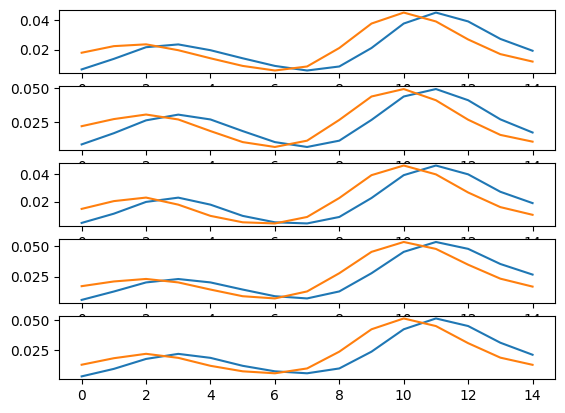

In [ ]:
for ii, idxs in enumerate(range(25,30)):
    plt.subplot(5,1,ii+1)
    plt.plot(dff_V1_L4_pyr_train[idxs])
    plt.plot(dff_V1_L4_pyr_test[idxs])

In [ ]:
train_loader = {}

In [ ]:
for cntr in range(nRuns):
    train_loader[cntr] = makeTensorLoaders((stacked_train_set,stacked_test_set),
                                           batch_size,shuffle=True)

#### Directory

In [ ]:
pp = '/content/drive/My Drive/Aish_celltypeRNN/Repeated-Runs-Dales-Pruning/Familiar-Change-Sparse-Frozen-Vanilla/'

In [ ]:
npp = {}
pp_npy = {}
pp_pts = {}

In [ ]:
for cntr in range(nRuns):

    npp[cntr] = 'celltype-dale-pruning-latent-16-'+str(cntr)+'/'
    pp_npy[cntr] = pp+npp[cntr]+'npys-'+str(cntr)+'/'
    pp_pts[cntr] = pp+npp[cntr]+'pts-'+str(cntr)+'/'

    os.mkdir(os.path.join(pp,npp[cntr]))
    os.mkdir(os.path.join(pp,npp[cntr],pp_npy[cntr]))
    os.mkdir(os.path.join(pp,npp[cntr],pp_pts[cntr]))

    os.mkdir(os.path.join(pp,npp[cntr],pp_npy[cntr],'Dataset/'))

#### Seeds

In [ ]:
seeds = np.random.randint(1000, size=nRuns)
np.save(pp_npy[cntr]+'seeds',seeds)

#### Block indices

In [ ]:
label_arr = ['V1_L4_pyr','V1_L4_sst','V1_L4_vip',
             'V1_L23_pyr','V1_L23_sst','V1_L23_vip',
             'V1_L5_pyr','V1_L5_sst','V1_L5_vip',
             'LM_L4_pyr','LM_L4_sst','LM_L4_vip',
             'LM_L23_pyr','LM_L23_sst','LM_L23_vip',
             'LM_L5_pyr','LM_L5_sst','LM_L5_vip']

In [ ]:
n_cell_types = len(label_arr)

In [ ]:
start_V1_L4_Pyr = 0
end_V1_L4_Pyr = start_V1_L4_Pyr + pop_list_types[0]*latent_scaling

start_V1_L4_SST = end_V1_L4_Pyr
end_V1_L4_SST = start_V1_L4_SST + pop_list_types[1]*latent_scaling

start_V1_L4_VIP = end_V1_L4_SST
end_V1_L4_VIP = start_V1_L4_VIP + pop_list_types[2]*latent_scaling

## V1, L2/3
start_V1_L23_Pyr = end_V1_L4_VIP
end_V1_L23_Pyr = start_V1_L23_Pyr + pop_list_types[0]*latent_scaling

start_V1_L23_SST = end_V1_L23_Pyr
end_V1_L23_SST = start_V1_L23_SST + pop_list_types[1]*latent_scaling

start_V1_L23_VIP = end_V1_L23_SST
end_V1_L23_VIP = start_V1_L23_VIP + pop_list_types[2]*latent_scaling

## V1, L5
start_V1_L5_Pyr = end_V1_L23_VIP
end_V1_L5_Pyr = start_V1_L5_Pyr + pop_list_types[0]*latent_scaling

start_V1_L5_SST = end_V1_L5_Pyr
end_V1_L5_SST = start_V1_L5_SST + pop_list_types[1]*latent_scaling

start_V1_L5_VIP = end_V1_L5_SST
end_V1_L5_VIP = start_V1_L5_VIP + pop_list_types[2]*latent_scaling

## LM, L4
start_LM_L4_Pyr = end_V1_L5_VIP ## would need to be changed if using L6 populations as well
end_LM_L4_Pyr = start_LM_L4_Pyr + pop_list_types[0]*latent_scaling

start_LM_L4_SST = end_LM_L4_Pyr
end_LM_L4_SST = start_LM_L4_SST + pop_list_types[1]*latent_scaling

start_LM_L4_VIP = end_LM_L4_SST
end_LM_L4_VIP = start_LM_L4_VIP + pop_list_types[2]*latent_scaling

## LM, L2/3
start_LM_L23_Pyr = end_LM_L4_VIP
end_LM_L23_Pyr = start_LM_L23_Pyr + pop_list_types[0]*latent_scaling

start_LM_L23_SST = end_LM_L23_Pyr
end_LM_L23_SST = start_LM_L23_SST + pop_list_types[1]*latent_scaling

start_LM_L23_VIP = end_LM_L23_SST
end_LM_L23_VIP = start_LM_L23_VIP + pop_list_types[2]*latent_scaling

## LM, L5
start_LM_L5_Pyr = end_LM_L23_VIP
end_LM_L5_Pyr = start_LM_L5_Pyr + pop_list_types[0]*latent_scaling

start_LM_L5_SST = end_LM_L5_Pyr
end_LM_L5_SST = start_LM_L5_SST + pop_list_types[1]*latent_scaling

start_LM_L5_VIP = end_LM_L5_SST
end_LM_L5_VIP = start_LM_L5_VIP + pop_list_types[2]*latent_scaling

#### Architecture

In [ ]:
# Define the neural network
class CelltypeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device):

        super(CelltypeRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh', bias=False)

        self.fc1 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc2 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc3 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc4 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc5 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc6 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc7 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc8 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc9 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)

        self.fc10 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc11 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc12 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc13 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc14 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc15 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc16 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc17 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc18 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)

        self.fc1.weight.requires_grad = False
        self.fc1.bias.requires_grad = False

        self.fc2.weight.requires_grad = False
        self.fc2.bias.requires_grad = False

        self.fc3.weight.requires_grad = False
        self.fc3.bias.requires_grad = False

        self.fc4.weight.requires_grad = False
        self.fc4.bias.requires_grad = False

        self.fc5.weight.requires_grad = False
        self.fc5.bias.requires_grad = False

        self.fc6.weight.requires_grad = False
        self.fc6.bias.requires_grad = False

        self.fc7.weight.requires_grad = False
        self.fc7.bias.requires_grad = False

        self.fc8.weight.requires_grad = False
        self.fc8.bias.requires_grad = False

        self.fc9.weight.requires_grad = False
        self.fc9.bias.requires_grad = False

        self.fc10.weight.requires_grad = False
        self.fc10.bias.requires_grad = False

        self.fc11.weight.requires_grad = False
        self.fc11.bias.requires_grad = False

        self.fc12.weight.requires_grad = False
        self.fc12.bias.requires_grad = False

        self.fc13.weight.requires_grad = False
        self.fc13.bias.requires_grad = False

        self.fc14.weight.requires_grad = False
        self.fc14.bias.requires_grad = False

        self.fc15.weight.requires_grad = False
        self.fc15.bias.requires_grad = False

        self.fc16.weight.requires_grad = False
        self.fc16.bias.requires_grad = False

        self.fc17.weight.requires_grad = False
        self.fc17.bias.requires_grad = False

        self.fc18.weight.requires_grad = False
        self.fc18.bias.requires_grad = False

        self.n_classes = num_classes
        self.device = device

    def forward(self, x):
        ## Define input mask
        in_mask = torch.zeros(self.hidden_size, self.input_size).to(device)
        in_mask[start_V1_L4_Pyr:end_V1_L4_Pyr,0] = 1
        in_mask[start_V1_L4_SST:end_V1_L4_SST,1] = 1
        in_mask[start_V1_L4_VIP:end_V1_L4_VIP,2] = 1

        in_mask[start_V1_L23_Pyr:end_V1_L23_Pyr,3] = 1
        in_mask[start_V1_L23_SST:end_V1_L23_SST,4] = 1
        in_mask[start_V1_L23_VIP:end_V1_L23_VIP,5] = 1

        in_mask[start_V1_L5_Pyr:end_V1_L5_Pyr,6] = 1
        in_mask[start_V1_L5_SST:end_V1_L5_SST,7] = 1
        in_mask[start_V1_L5_VIP:end_V1_L5_VIP,8] = 1

        in_mask[start_LM_L4_Pyr:end_LM_L4_Pyr,9] = 1
        in_mask[start_LM_L4_SST:end_LM_L4_SST,10] = 1
        in_mask[start_LM_L4_VIP:end_LM_L4_VIP,11] = 1

        in_mask[start_LM_L23_Pyr:end_LM_L23_Pyr,12] = 1
        in_mask[start_LM_L23_SST:end_LM_L23_SST,13] = 1
        in_mask[start_LM_L23_VIP:end_LM_L23_VIP,14] = 1

        in_mask[start_LM_L5_Pyr:end_LM_L5_Pyr,15] = 1
        in_mask[start_LM_L5_SST:end_LM_L5_SST,16] = 1
        in_mask[start_LM_L5_VIP:end_LM_L5_VIP,17] = 1

        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, inDim, nSteps = x.shape

        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)

        pred1 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred2 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred3 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred4 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred5 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred6 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred7 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred8 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred9 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)

        pred10 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred11 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred12 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred13 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred14 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred15 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred16 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred17 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred18 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)

        for ii in range(nSteps):
            ## Apply input mask
            self.rnn.weight_ih_l0.data.mul(in_mask)

            ip = torch.unsqueeze(x[:,:,ii],-1).view(nSamp,1,inDim)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
            fr_mask = ht.clone()>0
            htt = fr_mask*ht.clone() ## mask firing rate
            h0 = htt ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred1[:,ii,:] = self.fc1(ops[:, ii, start_V1_L4_Pyr:end_V1_L4_Pyr].clone())
            pred2[:,ii,:] = self.fc2(ops[:, ii, start_V1_L4_SST:end_V1_L4_SST].clone())
            pred3[:,ii,:] = self.fc3(ops[:, ii, start_V1_L4_VIP:end_V1_L4_VIP].clone())
            pred4[:,ii,:] = self.fc4(ops[:, ii, start_V1_L23_Pyr:end_V1_L23_Pyr].clone())
            pred5[:,ii,:] = self.fc5(ops[:, ii, start_V1_L23_SST:end_V1_L23_SST].clone())
            pred6[:,ii,:] = self.fc6(ops[:, ii, start_V1_L23_VIP:end_V1_L23_VIP].clone())
            pred7[:,ii,:] = self.fc7(ops[:, ii, start_V1_L5_Pyr:end_V1_L5_Pyr].clone())
            pred8[:,ii,:] = self.fc8(ops[:, ii, start_V1_L5_SST:end_V1_L5_SST].clone())
            pred9[:,ii,:] = self.fc9(ops[:, ii, start_V1_L5_VIP:end_V1_L5_VIP].clone())

            pred10[:,ii,:] = self.fc10(ops[:, ii, start_LM_L4_Pyr:end_LM_L4_Pyr].clone())
            pred11[:,ii,:] = self.fc11(ops[:, ii, start_LM_L4_SST:end_LM_L4_SST].clone())
            pred12[:,ii,:] = self.fc12(ops[:, ii, start_LM_L4_VIP:end_LM_L4_VIP].clone())
            pred13[:,ii,:] = self.fc13(ops[:, ii, start_LM_L23_Pyr:end_LM_L23_Pyr].clone())
            pred14[:,ii,:] = self.fc14(ops[:, ii, start_LM_L23_SST:end_LM_L23_SST].clone())
            pred15[:,ii,:] = self.fc15(ops[:, ii, start_LM_L23_VIP:end_LM_L23_VIP].clone())
            pred16[:,ii,:] = self.fc16(ops[:, ii, start_LM_L5_Pyr:end_LM_L5_Pyr].clone())
            pred17[:,ii,:] = self.fc17(ops[:, ii, start_LM_L5_SST:end_LM_L5_SST].clone())
            pred18[:,ii,:] = self.fc18(ops[:, ii, start_LM_L5_VIP:end_LM_L5_VIP].clone())

        out1 = pred1.clone() #Take the output from the last time step
        out2 = pred2.clone() #Take the output from the last time step
        out3 = pred3.clone() #Take the output from the last time step
        out4 = pred4.clone() #Take the output from the last time step
        out5 = pred5.clone() #Take the output from the last time step
        out6 = pred6.clone() #Take the output from the last time step
        out7 = pred7.clone() #Take the output from the last time step
        out8 = pred8.clone() #Take the output from the last time step
        out9 = pred9.clone() #Take the output from the last time step

        out10 = pred10.clone() #Take the output from the last time step
        out11 = pred11.clone() #Take the output from the last time step
        out12 = pred12.clone() #Take the output from the last time step
        out13 = pred13.clone() #Take the output from the last time step
        out14 = pred14.clone() #Take the output from the last time step
        out15 = pred15.clone() #Take the output from the last time step
        out16 = pred16.clone() #Take the output from the last time step
        out17 = pred17.clone() #Take the output from the last time step
        out18 = pred18.clone() #Take the output from the last time step

        return torch.dstack((out1,out2, out3, out4, out5, out6, out7, out8, out9,
                             out10,out11, out12, out13, out14, out15, out16, out17, out18)), htt

In [ ]:
model = {}
optimizer = {}
scheduler = {}

In [ ]:
criterion = nn.MSELoss()
eta = 0.001

In [ ]:
for cntr in range(nRuns):
    model[cntr] = CelltypeRNN(18, N, 1, device)
    model[cntr].to(device)
    optimizer[cntr] = torch.optim.Adam(model[cntr].parameters(), lr=eta)
    scheduler[cntr] = CosineAnnealingLR(optimizer[cntr], T_max=10, eta_min=0.0001)

In [ ]:
signs = np.tile([1,-1, -1], 6)

#### Weight initialization

In [ ]:
def initialize_weights(N, index_ranges, signs):
    weights = np.zeros((N, N))
    for ii, (start, end) in enumerate(index_ranges):
        limit = 1 / np.sqrt(N) if signs[ii] == 1 else -1/np.sqrt(N)
        weights[:, start:end] = np.random.uniform(0, limit, size=(N, end-start))
    return weights

In [ ]:
def generate_mask(weights, index_ranges, signs):
    mask = np.zeros_like(weights)
    for i, (start, end) in enumerate(index_ranges):
        if signs[i] == 1:
            mask[:, start:end] = np.where(weights[:, start:end] > 0, 1, 0)
        elif signs[i] == -1:
            mask[:, start:end] = np.where(weights[:, start:end] < 0, 1, 0)
    return mask

In [ ]:
index_ranges = [(start_V1_L4_Pyr,end_V1_L4_Pyr),(start_V1_L4_SST,end_V1_L4_SST),(start_V1_L4_VIP,end_V1_L4_VIP),
                (start_V1_L23_Pyr,end_V1_L23_Pyr),(start_V1_L23_SST,end_V1_L23_SST),(start_V1_L23_VIP,end_V1_L23_VIP),
                (start_V1_L5_Pyr,end_V1_L5_Pyr),(start_V1_L5_SST,end_V1_L5_SST),(start_V1_L5_VIP,end_V1_L5_VIP),
                (start_LM_L4_Pyr,end_LM_L4_Pyr),(start_LM_L4_SST,end_LM_L4_SST),(start_LM_L4_VIP,end_LM_L4_VIP),
                (start_LM_L23_Pyr,end_LM_L23_Pyr),(start_LM_L23_SST,end_LM_L23_SST),(start_LM_L23_VIP,end_LM_L23_VIP),
                (start_LM_L5_Pyr,end_LM_L5_Pyr),(start_LM_L5_SST,end_LM_L5_SST),(start_LM_L5_VIP,end_LM_L5_VIP)]

In [ ]:
weights_init = {}
for cntr in range(nRuns):
    weights_init[cntr] = initialize_weights(N,index_ranges,signs)
    model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(weights_init[cntr]).float()
    torch.save(model[cntr].state_dict(),pp_pts[cntr]+'celltypeRNN-dale-initial-'+str(latent_scaling)+'.pt')

Text(0.5, 1.0, 'Initial Weights')

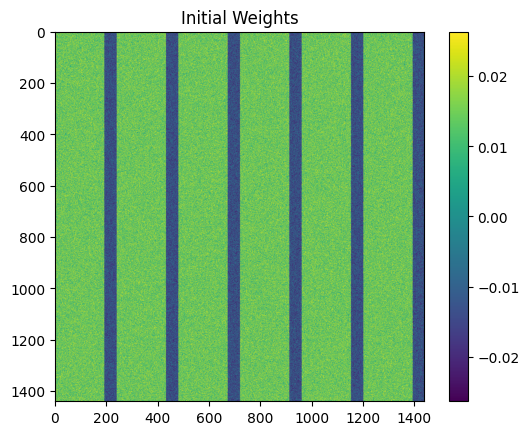

In [ ]:
kk = 0
plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights')

#### Test data pass

In [ ]:
for inputs, targets in train_loader[cntr]:
    if train_on_gpu:
        inputs, targets = inputs.float().cuda(), targets.float().cuda()
        inputs = inputs.permute(0,2,1)
        targets_f = torch.dstack((torch.squeeze(targets)[:,:,0],torch.squeeze(targets)[:,:,1],torch.squeeze(targets)[:,:,2],
                                  torch.squeeze(targets)[:,:,3],torch.squeeze(targets)[:,:,4],torch.squeeze(targets)[:,:,5],
                                  torch.squeeze(targets)[:,:,6],torch.squeeze(targets)[:,:,7],torch.squeeze(targets)[:,:,8],
                                  torch.squeeze(targets)[:,:,9],torch.squeeze(targets)[:,:,10],torch.squeeze(targets)[:,:,11],
                                  torch.squeeze(targets)[:,:,12],torch.squeeze(targets)[:,:,13],torch.squeeze(targets)[:,:,14],
                                  torch.squeeze(targets)[:,:,15],torch.squeeze(targets)[:,:,16],torch.squeeze(targets)[:,:,17]))
        model[cntr].cuda()
    else:
        inputs, targets = inputs.float(), targets.float()
        inputs = inputs.permute(0,2,1)
        targets_f = torch.dstack((torch.squeeze(targets)[:,:,0],torch.squeeze(targets)[:,:,1],torch.squeeze(targets)[:,:,2,:],
                                  torch.squeeze(targets)[:,:,3],torch.squeeze(targets)[:,:,4],torch.squeeze(targets)[:,:,5,:],
                                  torch.squeeze(targets)[:,:,6],torch.squeeze(targets)[:,:,7],torch.squeeze(targets)[:,:,8,:],
                                  torch.squeeze(targets)[:,:,9],torch.squeeze(targets)[:,:,10],torch.squeeze(targets)[:,:,11,:],
                                  torch.squeeze(targets)[:,:,12],torch.squeeze(targets)[:,:,13],torch.squeeze(targets)[:,:,14,:],
                                  torch.squeeze(targets)[:,:,15],torch.squeeze(targets)[:,:,16],torch.squeeze(targets)[:,:,17,:]))

In [ ]:
inputs.shape

torch.Size([200, 18, 15])

In [ ]:
targets.shape

torch.Size([200, 15, 18])

In [ ]:
targets_f.shape

torch.Size([200, 15, 18])

In [ ]:
oo, fr = model[cntr](inputs)

In [ ]:
oo.shape

torch.Size([200, 15, 18])

### Training

In [ ]:
n_epochs = 70

In [ ]:
train_losses_celltype = {}
train_losses = {}
for cntr in range(nRuns):
    train_losses[cntr] = np.zeros(n_epochs)
    for nn in range(n_cell_types):
        train_losses_celltype[cntr,nn] = np.zeros(n_epochs)

In [ ]:
targets_f_batch = {}
inputs_batch = {}

In [ ]:
for cntr in range(nRuns):
    print(f'Run: {cntr}')
    model[cntr].train()
    train_loss_min = np.inf

    for epoch in tqdm(range(1, n_epochs+1)):

        train_loss = 0.0

        for inputs, targets in train_loader[cntr]:
            if train_on_gpu:
                inputs, targets = inputs.float().cuda(), targets.float().cuda()
                inputs = inputs.permute(0,2,1)
                targets_f = torch.dstack((torch.squeeze(targets)[:,:,0],torch.squeeze(targets)[:,:,1],torch.squeeze(targets)[:,:,2],
                                  torch.squeeze(targets)[:,:,3],torch.squeeze(targets)[:,:,4],torch.squeeze(targets)[:,:,5],
                                  torch.squeeze(targets)[:,:,6],torch.squeeze(targets)[:,:,7],torch.squeeze(targets)[:,:,8],
                                  torch.squeeze(targets)[:,:,9],torch.squeeze(targets)[:,:,10],torch.squeeze(targets)[:,:,11],
                                  torch.squeeze(targets)[:,:,12],torch.squeeze(targets)[:,:,13],torch.squeeze(targets)[:,:,14],
                                  torch.squeeze(targets)[:,:,15],torch.squeeze(targets)[:,:,16],torch.squeeze(targets)[:,:,17]))
                model[cntr].cuda()
            else:
                inputs, targets = inputs.float(), targets.float()
                inputs = inputs.permute(0,2,1)
                targets_f = torch.dstack((torch.squeeze(targets)[:,:,0],torch.squeeze(targets)[:,:,1],torch.squeeze(targets)[:,:,2],
                                  torch.squeeze(targets)[:,:,3],torch.squeeze(targets)[:,:,4],torch.squeeze(targets)[:,:,5],
                                  torch.squeeze(targets)[:,:,6],torch.squeeze(targets)[:,:,7],torch.squeeze(targets)[:,:,8],
                                  torch.squeeze(targets)[:,:,9],torch.squeeze(targets)[:,:,10],torch.squeeze(targets)[:,:,11],
                                  torch.squeeze(targets)[:,:,12],torch.squeeze(targets)[:,:,13],torch.squeeze(targets)[:,:,14],
                                  torch.squeeze(targets)[:,:,15],torch.squeeze(targets)[:,:,16],torch.squeeze(targets)[:,:,17]))

            optimizer[cntr].zero_grad()
            outputs, firing_rates = model[cntr](inputs)
            outputs = torch.squeeze(outputs)
            if train_on_gpu:
                outputs = outputs.cuda()

            loss = criterion(outputs, targets_f)
            train_loss += loss.item() #update training loss

            loss.backward()
            optimizer[cntr].step()

            ## Dale's backprop
            #w = model[cntr].rnn.weight_hh_l0.detach().cpu().numpy()
            #mask = generate_mask(w, index_ranges, signs)
            #wm = w*mask
            #model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(wm).float().cuda()

        if train_loss< train_loss_min:

            #print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            train_loss_min = train_loss
            torch.save(model[cntr].state_dict(),pp_pts[cntr]+'celltypeRNN-dale-dense-'+str(latent_scaling)+'.pt')

        for nnn in range(n_cell_types):
            train_losses_celltype[cntr,nnn][epoch-1] = criterion(outputs[:,:,nnn], targets_f[:,:,nnn])

        train_losses[cntr] = train_loss

        scheduler[cntr].step()

        targets_f_batch[cntr] = targets_f
        inputs_batch[cntr] = inputs

        if epoch%20 == 0:
            print(f'Epoch: {epoch}')
            print(f'Train loss: {train_loss}')

Run: 0


 29%|██▊       | 20/70 [01:39<04:04,  4.90s/it]

Epoch: 20
Train loss: 0.01841051795054227


 57%|█████▋    | 40/70 [03:17<02:32,  5.08s/it]

Epoch: 40
Train loss: 0.01409604656510055


 86%|████████▌ | 60/70 [04:55<00:48,  4.88s/it]

Epoch: 60
Train loss: 0.01156225090380758


100%|██████████| 70/70 [05:45<00:00,  4.93s/it]


Run: 1


 29%|██▊       | 20/70 [01:38<04:04,  4.89s/it]

Epoch: 20
Train loss: 0.023272118531167507


 57%|█████▋    | 40/70 [03:17<02:29,  4.97s/it]

Epoch: 40
Train loss: 0.018890997394919395


 86%|████████▌ | 60/70 [04:56<00:49,  4.92s/it]

Epoch: 60
Train loss: 0.01589283416979015


100%|██████████| 70/70 [05:45<00:00,  4.93s/it]


Run: 2


 29%|██▊       | 20/70 [01:38<04:08,  4.97s/it]

Epoch: 20
Train loss: 0.011263787164352834


 57%|█████▋    | 40/70 [03:18<02:27,  4.92s/it]

Epoch: 40
Train loss: 0.008554453903343529


 86%|████████▌ | 60/70 [04:56<00:49,  4.95s/it]

Epoch: 60
Train loss: 0.007800035702530295


100%|██████████| 70/70 [05:46<00:00,  4.94s/it]


Run: 3


 29%|██▊       | 20/70 [01:38<04:05,  4.91s/it]

Epoch: 20
Train loss: 0.021042687818408012


 57%|█████▋    | 40/70 [03:16<02:28,  4.94s/it]

Epoch: 40
Train loss: 0.017747766221873462


 86%|████████▌ | 60/70 [04:53<00:48,  4.83s/it]

Epoch: 60
Train loss: 0.014850527746602893


100%|██████████| 70/70 [05:42<00:00,  4.89s/it]


Run: 4


 29%|██▊       | 20/70 [01:36<04:01,  4.83s/it]

Epoch: 20
Train loss: 0.015074434923008084


 57%|█████▋    | 40/70 [03:14<02:25,  4.86s/it]

Epoch: 40
Train loss: 0.012344885035417974


 86%|████████▌ | 60/70 [04:51<00:48,  4.86s/it]

Epoch: 60
Train loss: 0.01106084301136434


100%|██████████| 70/70 [05:40<00:00,  4.86s/it]


### Weight analysis (Post training - Pre pruning)

In [ ]:
# plt.plot(train_losses[0])
# plt.title('Total loss curve')
# plt.xlabel('Epochs')
# plt.ylabel('MSE')

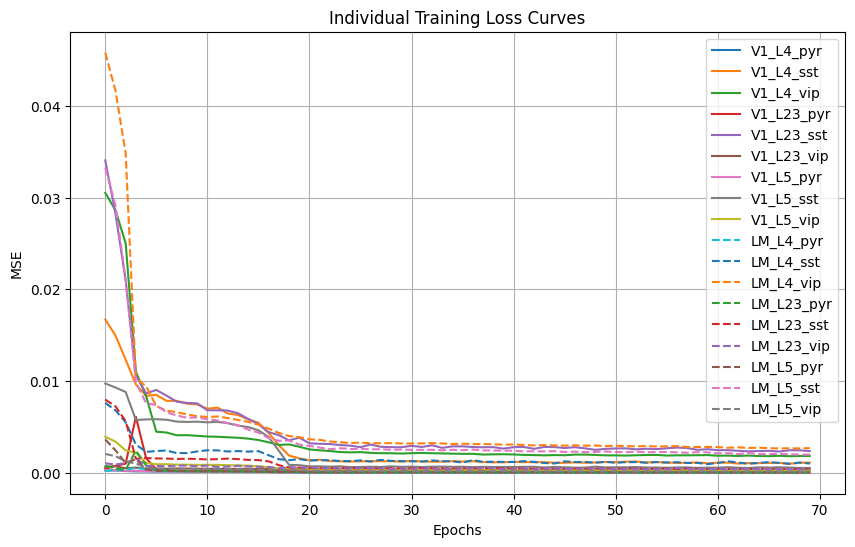

In [ ]:
run = 2

# Plotting
plt.figure(figsize=(10, 6))
plt.title('Individual Training Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('MSE')

for ii in range(n_cell_types):
    if ii < np.round(n_cell_types//2):
        plt.plot(train_losses_celltype[run,ii],'-',label=label_arr[ii])
    else:
        plt.plot(train_losses_celltype[run,ii],'--',label=label_arr[ii])

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
outputs_np = outputs.detach().cpu().numpy()
targets_np = targets_f.detach().cpu().numpy()

In [ ]:
outputs_np.shape

(200, 15, 18)

In [ ]:
targets_np.shape

(200, 15, 18)

Text(0.5, 1.0, 'LM_L4_sst')

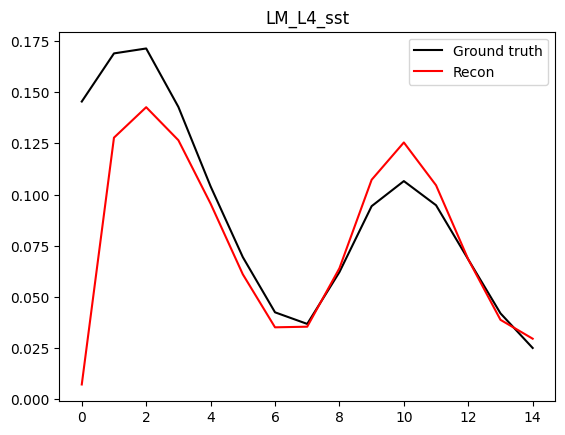

In [ ]:
ex = 2
ii = 10

# target_batch = targets_np[ii*batch_size:(ii+1)*batch_size]
target_curve = targets_np[ex,:,ii]
plt.plot(target_curve,color='k',label='Ground truth')

# output_batch = outputs_np[ii*batch_size:(ii+1)*batch_size]
output_curve = outputs_np[ex,:,ii]
plt.plot(output_curve, color='r',label='Recon')
plt.legend()
plt.title(label_arr[ii])

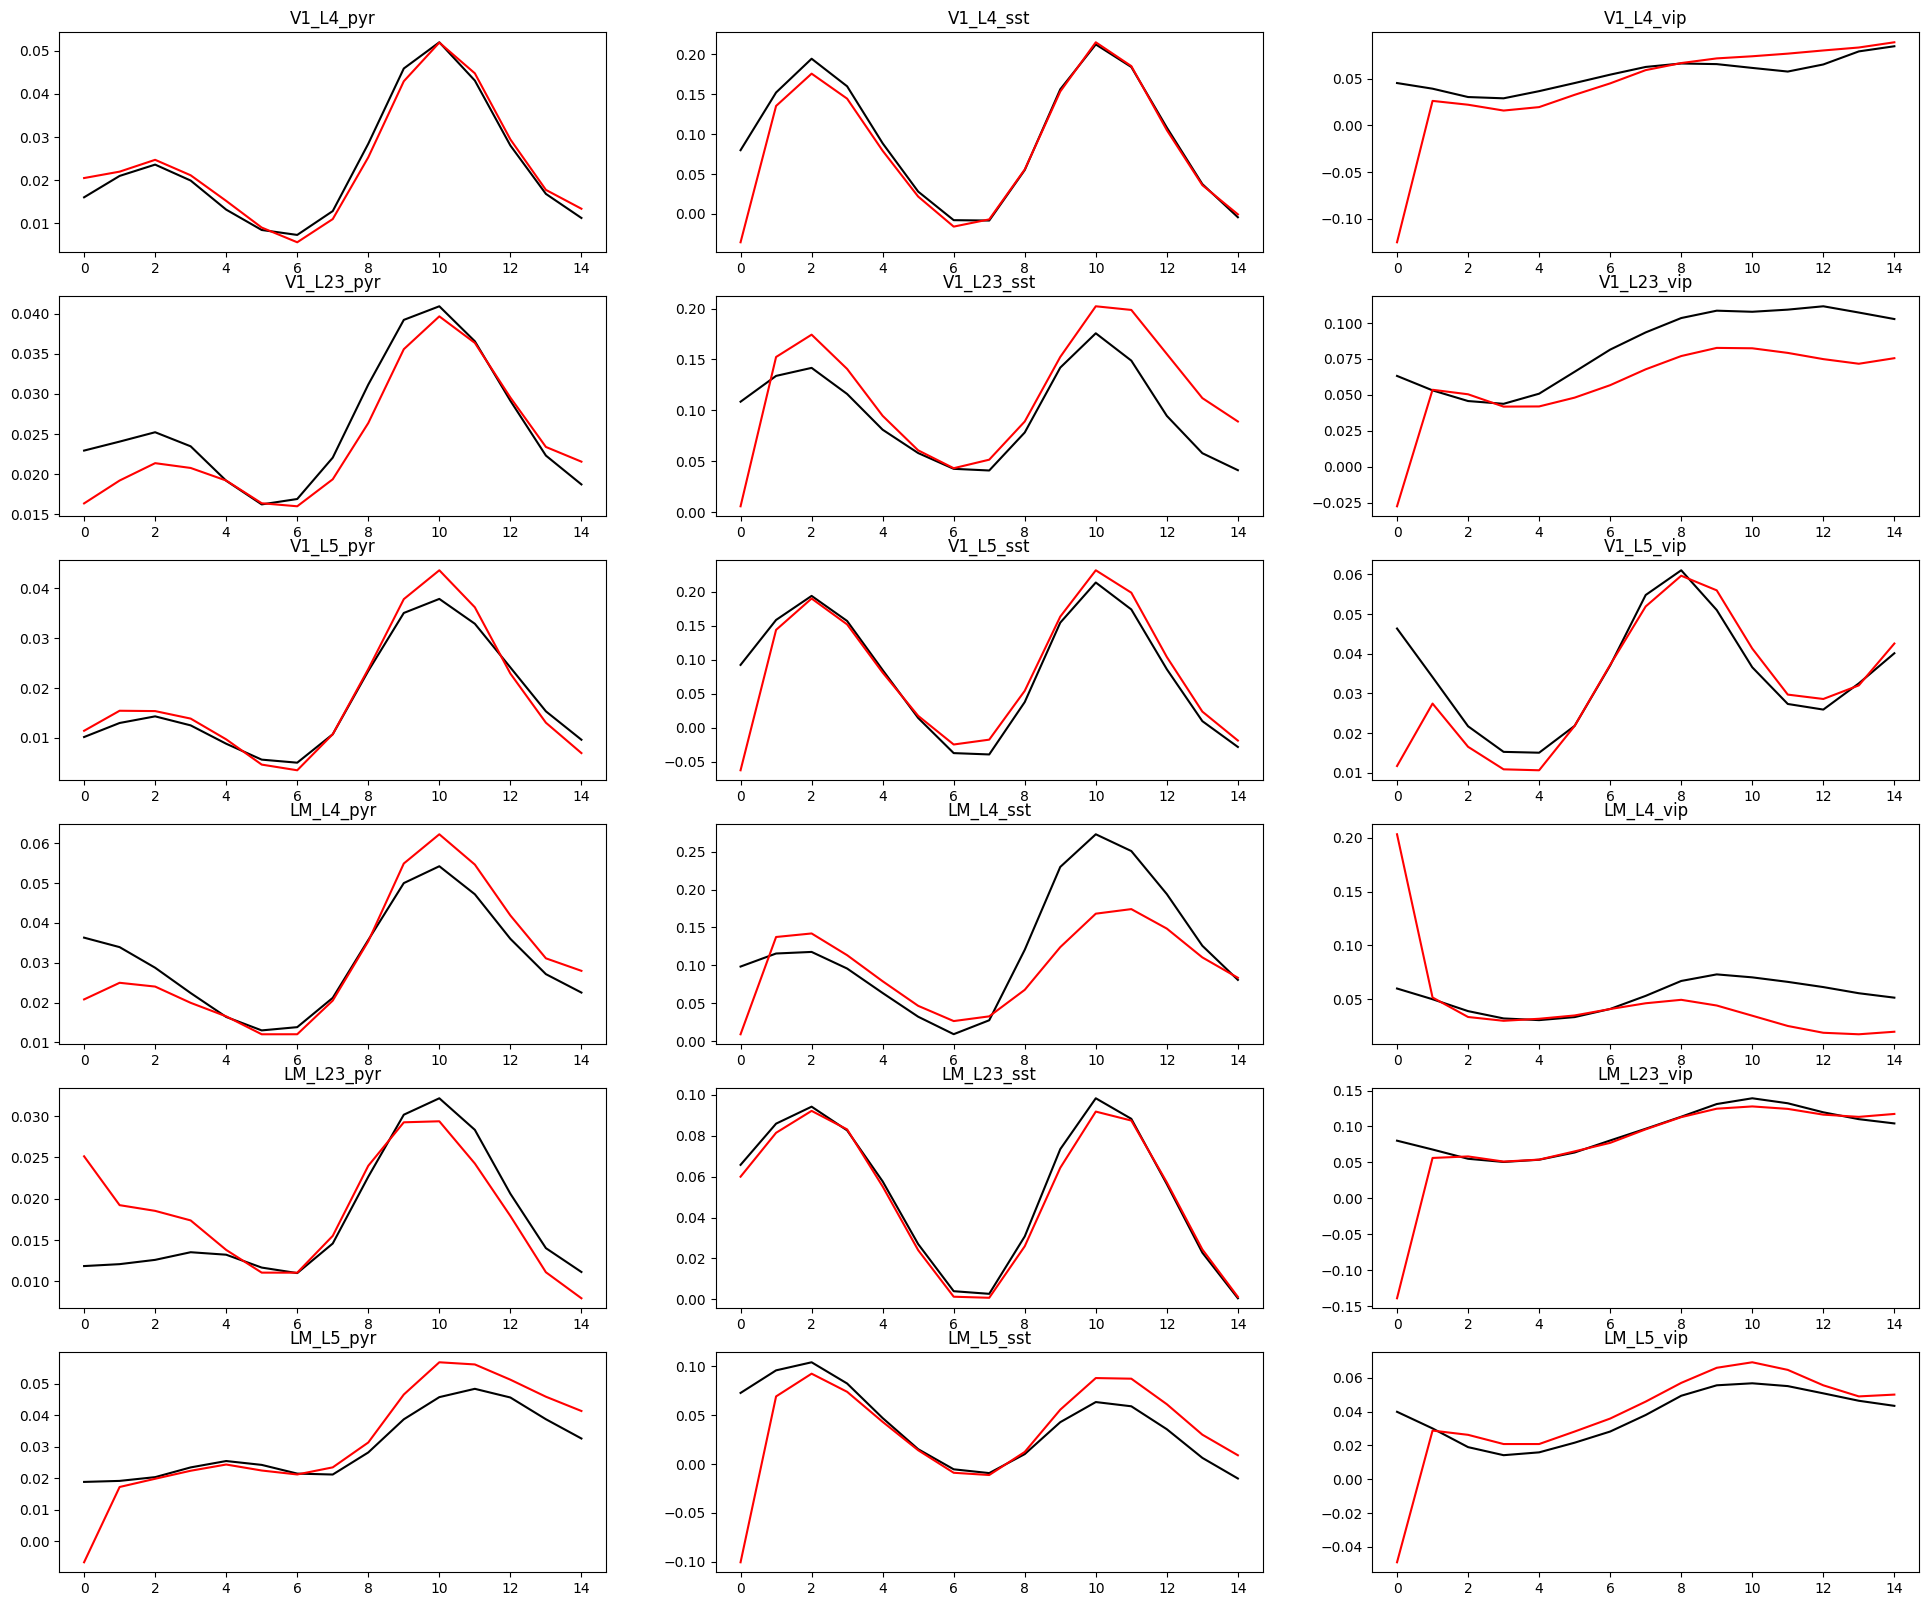

In [ ]:
ex = 0

plt.figure(figsize=(24,20))

for ii in range(n_cell_types):
    plt.subplot(6,3,ii+1)

    target_curve = targets_np[ex,:,ii]
    plt.plot(target_curve,color='k')

    output_curve = outputs_np[ex,:,ii]
    plt.plot(output_curve,color='r')

    plt.title(label_arr[ii])

In [ ]:
conn_mtx_final = {}
conn_mtx_init = {}

In [ ]:
# conn_mtx_final = (model[0].rnn._parameters['weight_hh_l0'].cpu().detach().numpy())
# conn_mtx_init = weights_init[0]

In [ ]:
for cntr in range(nRuns):
    conn_mtx_init[cntr] = weights_init[cntr]
    model[cntr].load_state_dict(torch.load(pp_pts[cntr]+'celltypeRNN-dale-dense-'+str(latent_scaling)+'.pt'))
    conn_mtx_final[cntr] = (model[cntr].rnn._parameters['weight_hh_l0'].cpu().detach().numpy())

0.27983344


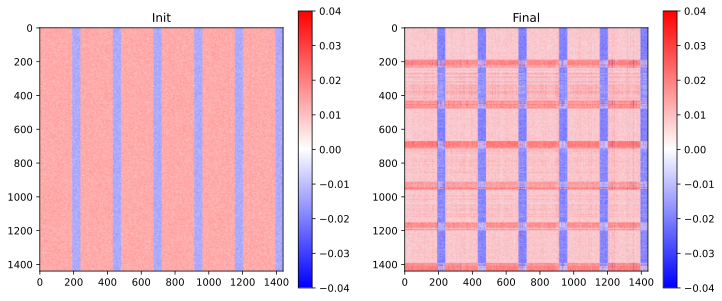

In [ ]:
ff = plt.figure(figsize=(12,5))

run = 2

plt.subplot(121)
plt.imshow(conn_mtx_init[run], cmap='bwr')
plt.title("Init")
plt.colorbar()
plt.clim(-0.04,0.04)

plt.subplot(122)
v_max = np.max(np.abs(conn_mtx_final[run]))
print(v_max)
plt.imshow(conn_mtx_final[run], cmap='bwr', vmin = -v_max, vmax= v_max)
plt.title("Final")
plt.colorbar()
plt.clim(-0.04,0.04)

plt.savefig(pp + 'before_pruning_vanilla_backprop.svg', format="svg", dpi=300)
#'/content/drive/My Drive/Aish_celltypeRNN/Repeated-Runs-Dales-Pruning/Familiar-Change-Sparse-Frozen-Vanilla/'

0.27983344


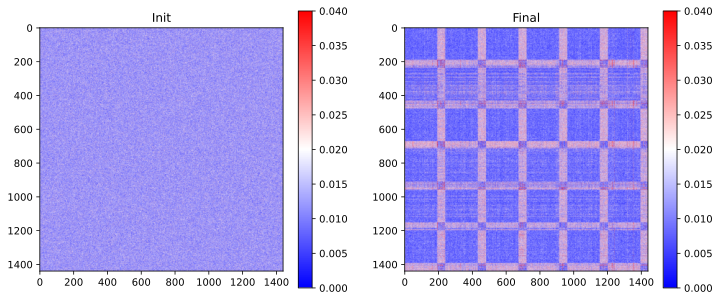

In [ ]:
ff = plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(np.abs(conn_mtx_init[run]), cmap='bwr')
plt.title("Init")
plt.colorbar()
plt.clim(0.0,0.04)

plt.subplot(122)
print(np.max(np.abs(conn_mtx_final[run])))
plt.imshow(np.abs(conn_mtx_final[run]), cmap='bwr')
plt.title("Final")
plt.colorbar()
plt.clim(0.0,0.04)

plt.save()

In [ ]:
def average_weights_in_blocks_matrix(weight_matrix, block_indices, use_absolute_values=False):
    n_blocks = len(block_indices)
    averages_matrix = np.zeros((n_blocks, n_blocks))

    for i, (start_i, end_i) in enumerate(block_indices):
        for j, (start_j, end_j) in enumerate(block_indices):
            block_weights = weight_matrix[start_i:end_i, start_j:end_j]  # Extract the block of weights ##had +1 at end_js

            if use_absolute_values:
                block_weights = np.abs(block_weights)

            block_average = np.mean(block_weights)  # Calculate the average
            averages_matrix[i, j] = block_average

    return averages_matrix

In [ ]:
block_indices = [(start_V1_L4_Pyr,end_V1_L4_Pyr), (start_V1_L4_SST,end_V1_L4_SST), (start_V1_L4_VIP,end_V1_L4_VIP),
                 (start_V1_L23_Pyr,end_V1_L23_Pyr), (start_V1_L23_SST,end_V1_L23_SST), (start_V1_L23_VIP,end_V1_L23_VIP),
                 (start_V1_L5_Pyr,end_V1_L5_Pyr), (start_V1_L5_SST,end_V1_L5_SST), (start_V1_L5_VIP,end_V1_L5_VIP),
                 (start_LM_L4_Pyr,end_LM_L4_Pyr), (start_LM_L4_SST,end_LM_L4_SST), (start_LM_L4_VIP,end_LM_L4_VIP),
                 (start_LM_L23_Pyr,end_LM_L23_Pyr), (start_LM_L23_SST,end_LM_L23_SST), (start_LM_L23_VIP,end_LM_L23_VIP),
                 (start_LM_L5_Pyr,end_LM_L5_Pyr), (start_LM_L5_SST,end_LM_L5_SST), (start_LM_L5_VIP,end_LM_L5_VIP)]

In [ ]:
block_indices_layers = [(start_V1_L4_Pyr,end_V1_L4_VIP), (start_V1_L23_Pyr,end_V1_L23_VIP), (start_V1_L5_Pyr,end_V1_L5_VIP),
                        (start_LM_L4_Pyr,end_LM_L4_VIP), (start_LM_L23_Pyr,end_LM_L23_VIP), (start_LM_L5_Pyr,end_LM_L5_VIP)]

In [ ]:
label_arr_layers = ['V1_L4', 'V1_L23', 'V1_L5', 'LM_L4', 'LM_L23', 'LM_L5']

In [ ]:
block_indices_areas = [(start_V1_L4_Pyr,end_V1_L5_VIP), (start_LM_L4_Pyr,end_LM_L5_VIP)]

In [ ]:
label_arr_areas = ['V1','LM']

#### Construct connection probabilities and sparsities matrix

In [ ]:
df = (pd.read_csv('/content/drive/MyDrive/Aish_celltypeRNN/frozen-readout-celltype-training/connection-probs-full.csv',header=None))
conn_df = df[(df[1] != 'L6') & (df[2] != 'L6')]

In [ ]:
conn_df

,0,1,2,3,4,5,6
0,connection-probability,pre-layer,post-layer,pre-cell-type,post-cell-type,presynaptic,postsynaptic
1,0.06,L2/3,L2/3,Pyr,Pyr,L2/3: Pyr,L2/3: Pyr
2,0.3,L2/3,L2/3,Pyr,SST,L2/3: Pyr,L2/3: SST
3,0.16,L2/3,L2/3,Pyr,ViP,L2/3: Pyr,L2/3: ViP
4,0.05,L2/3,L4,Pyr,Pyr,L2/3: Pyr,L4: Pyr
...,...,...,...,...,...,...,...
101,0.2,L5,L4,ViP,SST,L5: ViP,L4: SST
102,0.0,L5,L4,ViP,ViP,L5: ViP,L4: ViP
103,0.0,L5,L5,ViP,Pyr,L5: ViP,L5: Pyr
104,0.05,L5,L5,ViP,SST,L5: ViP,L5: SST


In [ ]:
cell_types = ['Pyr', 'SST', 'ViP']
layers = ['L4','L2/3','L5']

In [ ]:
combos = []
for ii, layer in enumerate(layers):
    for jj, cell in enumerate(cell_types):
        pop = layer + ': ' + cell
        combos.append(pop)

In [ ]:
combos

['L4: Pyr',
 'L4: SST',
 'L4: ViP',
 'L2/3: Pyr',
 'L2/3: SST',
 'L2/3: ViP',
 'L5: Pyr',
 'L5: SST',
 'L5: ViP']

In [ ]:
conn_probs = np.zeros((len(combos),len(combos)))
for col, pre_syn in enumerate(combos):
    for row, post_syn in enumerate(combos):
        conn_probs[row, col] = float(conn_df[(conn_df[5] == pre_syn) & (conn_df[6] == post_syn)].iloc[0, 0])

In [ ]:
sparsities = 1-conn_probs
print('Connection probs: ',conn_probs)
print('Sparsities: ',sparsities)

Connection probs:  [[0.1  0.22 0.   0.05 0.04 0.   0.   0.19 0.  ]
 [0.04 0.01 0.14 0.17 0.   0.14 0.08 0.04 0.2 ]
 [0.   0.22 0.03 0.   0.13 0.05 0.02 0.14 0.  ]
 [0.07 0.33 0.   0.06 0.23 0.05 0.   0.15 0.  ]
 [0.04 0.05 0.25 0.3  0.05 0.14 0.   0.05 0.  ]
 [0.02 0.21 0.   0.16 0.3  0.01 0.   0.13 0.  ]
 [0.   0.08 0.   0.08 0.   0.   0.04 0.15 0.  ]
 [0.03 0.04 0.11 0.04 0.   0.   0.1  0.03 0.05]
 [0.11 0.07 0.04 0.   0.   0.04 0.02 0.1  0.03]]
Sparsities:  [[0.9  0.78 1.   0.95 0.96 1.   1.   0.81 1.  ]
 [0.96 0.99 0.86 0.83 1.   0.86 0.92 0.96 0.8 ]
 [1.   0.78 0.97 1.   0.87 0.95 0.98 0.86 1.  ]
 [0.93 0.67 1.   0.94 0.77 0.95 1.   0.85 1.  ]
 [0.96 0.95 0.75 0.7  0.95 0.86 1.   0.95 1.  ]
 [0.98 0.79 1.   0.84 0.7  0.99 1.   0.87 1.  ]
 [1.   0.92 1.   0.92 1.   1.   0.96 0.85 1.  ]
 [0.97 0.96 0.89 0.96 1.   1.   0.9  0.97 0.95]
 [0.89 0.93 0.96 1.   1.   0.96 0.98 0.9  0.97]]


#### Pruning

In [ ]:
def topo_noise_prune(A, s):

    N_post = A.shape[0]
    N_pre = A.shape[1]
    A_sparse = np.zeros_like(A)

    z0 = np.sum(A==0) + np.min((N_pre,N_post))
    if z0 > 0:
        z = s*np.prod(A.shape)
        s = (z-z0)/(np.prod(A.shape)-z0)

    if N_post == N_pre:
        D = -1*np.diag(np.diag(A))
        W = A #+ D
    else:
        d_vals = -1*np.diag(A)
        D = np.zeros_like(A)
        np.fill_diagonal(D, d_vals)
        W = A #+ D

    K = N_pre*N_post*(1-s)/np.sum(np.abs(W))

    for ii in range(N_post):
        for jj in range(N_pre):

            if np.abs(W[ii,jj])>0:
                Pij = K*(np.abs(W[ii,jj]))
                if np.random.uniform() < Pij:
                    A_sparse[ii,jj] = A[ii,jj]

    return A_sparse, K

In [ ]:
def prune_in_blocks(matrix, block_indices, etas_mat):
    # Initialize the pruned matrix with zeros
    A_block_pruned = np.zeros_like(matrix)
    block_sparsities = -1*np.ones_like(etas_mat)

    # Process each block and place it into A_pruned
    for pre, (start_pre, end_pre) in enumerate(block_indices):
        for post, (start_post, end_post) in enumerate(block_indices):

            # Extract the block from the original matrix
            block = matrix[start_post:end_post, start_pre:end_pre]
            # Process the block using the prune function
            pruned_block, _ = topo_noise_prune(block, etas_mat[post,pre])
            # Place the pruned block into the pruned matrix
            A_block_pruned[start_post:end_post, start_pre:end_pre] = pruned_block

            block_sparsities[post,pre] = np.sum(pruned_block==0)/np.prod(pruned_block.shape)

    return A_block_pruned, block_sparsities

In [ ]:
intra_indices_V1 = []

ss = 0
for ii, layer in enumerate(layers):
    for jj, cell in enumerate(cell_types):
        ee = ss + pop_list_types[jj]*latent_scaling
        intra_indices_V1.append((ss,ee))
        ss = ee

intra_indices_V1 = np.array(intra_indices_V1)
intra_indices_LM = intra_indices_V1 + n_depths*sum(pop_list_types)*latent_scaling

In [ ]:
V1_block_pruned = {}
V1_block_sparsities = {}

LM_block_pruned = {}
LM_block_sparsities = {}

In [ ]:
# Process blocks and get the pruned intra-areal connectivity matrix
for cntr in range(nRuns):
    V1_block_pruned[cntr], V1_block_sparsities[cntr] = prune_in_blocks(conn_mtx_final[cntr], intra_indices_V1, sparsities)
    LM_block_pruned[cntr], LM_block_sparsities[cntr] = prune_in_blocks(conn_mtx_final[cntr], intra_indices_LM, sparsities)

In [ ]:
conn_mtx_final_pruned = {}

In [ ]:
for cntr in range(nRuns):
    conn_mtx_final_pruned[cntr] = conn_mtx_final[cntr].copy()
    conn_mtx_final_pruned[cntr][start_V1_L4_Pyr:end_V1_L5_VIP,
                          start_V1_L4_Pyr:end_V1_L5_VIP] = V1_block_pruned[cntr][start_V1_L4_Pyr:end_V1_L5_VIP,
                                                                            start_V1_L4_Pyr:end_V1_L5_VIP]
    conn_mtx_final_pruned[cntr][start_LM_L4_Pyr:end_LM_L5_VIP,
                          start_LM_L4_Pyr:end_LM_L5_VIP] = LM_block_pruned[cntr][start_LM_L4_Pyr:end_LM_L5_VIP,
                                                                            start_LM_L4_Pyr:end_LM_L5_VIP]

In [ ]:
rnn_mask = {}
for cntr in range(nRuns):
    rnn_mask[cntr] = torch.from_numpy((conn_mtx_final_pruned[cntr]!=0).astype(int)).float().cuda()

#### Define inter-areal mask

In [ ]:
p = 0.3
mask_inter_areal = {}

In [ ]:
for cntr in range(nRuns):
    mask_inter_areal[cntr] = np.ones((N,N))

    mask_inter_areal[cntr][start_LM_L4_Pyr:end_LM_L5_VIP, start_V1_L4_Pyr:end_V1_L5_VIP] = 0.
    mask_inter_areal[cntr][start_V1_L4_Pyr:end_V1_L5_VIP, start_LM_L4_Pyr:end_LM_L5_VIP] = 0.

    s1 = mask_inter_areal[cntr][start_LM_L4_Pyr:end_LM_L4_VIP, start_V1_L23_Pyr:end_V1_L23_Pyr].shape
    mask_inter_areal[cntr][start_LM_L4_Pyr:end_LM_L4_VIP, start_V1_L23_Pyr:end_V1_L23_Pyr] = np.random.binomial(1, p, size=s1)

    s2 = mask_inter_areal[cntr][start_V1_L23_Pyr:end_V1_L23_VIP, start_LM_L5_Pyr:end_LM_L5_Pyr].shape
    mask_inter_areal[cntr][start_V1_L23_Pyr:end_V1_L23_VIP, start_LM_L5_Pyr:end_LM_L5_Pyr] = np.random.binomial(1, p, size=s2)

    s3 = mask_inter_areal[cntr][start_V1_L5_Pyr:end_V1_L5_VIP, start_LM_L5_Pyr:end_LM_L5_Pyr].shape
    mask_inter_areal[cntr][start_V1_L5_Pyr:end_V1_L5_VIP, start_LM_L5_Pyr:end_LM_L5_Pyr] = np.random.binomial(1, p, size=s3)

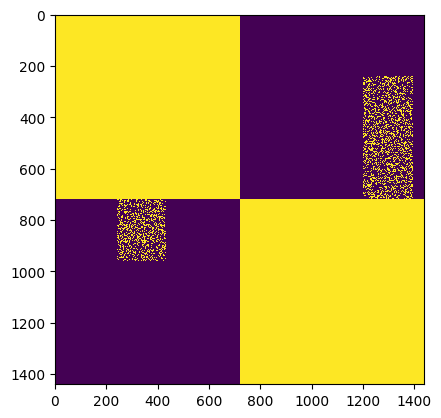

In [ ]:
plt.imshow(mask_inter_areal[0], interpolation='nearest')

#### Substitute weights

In [ ]:
model_pruned = {}
for cntr in range(nRuns):
    model_pruned[cntr] = model[cntr]
    model_pruned[cntr] = model_pruned[cntr].cuda()
    model_pruned[cntr].rnn.weight_hh_l0.data = model_pruned[cntr].rnn.weight_hh_l0.data.copy_(torch.from_numpy(conn_mtx_final_pruned[cntr]*mask_inter_areal[cntr]).float().cuda())
    model_pruned[cntr] = model_pruned[cntr].float()

In [ ]:
mask_inter_areal_tensor = {}
for cntr in range(nRuns):
    mask_inter_areal_tensor[cntr] = torch.from_numpy(mask_inter_areal[cntr])
    if train_on_gpu:
        mask_inter_areal_tensor[cntr] = mask_inter_areal_tensor[cntr].float().cuda()

#### Check loss with purely pruned model

In [ ]:
errors = {}
for cntr in range(nRuns):
    op, frp = model_pruned[cntr](inputs_batch[cntr])
    op = torch.squeeze(op)
    errors[cntr] = criterion(op.cuda(), targets_f_batch[cntr])

In [ ]:
errors

{0: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>),
 1: tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>),
 2: tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>),
 3: tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward0>),
 4: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)}

#### Retrain weights

In [ ]:
finetune_optimizer = {}
finetune_scheduler = {}
for cntr in range(nRuns):
    finetune_optimizer[cntr] = optim.Adam(model_pruned[cntr].parameters(), lr=0.001)
    finetune_scheduler[cntr] = CosineAnnealingLR(finetune_optimizer[cntr], T_max=10, eta_min=0.0001)

In [ ]:
n_epochs_finetune = 50

In [ ]:
train_losses_pruned = {}
train_losses_celltype_pruned = {}

for cntr in range(nRuns):
    train_losses_pruned[cntr] = np.zeros(n_epochs_finetune)
    for nnn in range(n_cell_types):
        train_losses_celltype_pruned[cntr,nnn] = np.zeros(n_epochs_finetune)

In [ ]:
for cntr in range(nRuns):
    print(f'Run: {cntr}')
    model_pruned[cntr].train()
    train_loss_min = errors[cntr]

    for epoch in tqdm(range(1, n_epochs_finetune+1)):

        train_loss = 0.0
        for inputs, targets in train_loader[cntr]:
            if train_on_gpu:
                inputs, targets = inputs.float().cuda(), torch.unsqueeze(targets.float().cuda(),-1)
                inputs = inputs.permute(0,2,1)
                targets_f = torch.dstack((torch.squeeze(targets)[:,:,0],torch.squeeze(targets)[:,:,1],torch.squeeze(targets)[:,:,2],
                                  torch.squeeze(targets)[:,:,3],torch.squeeze(targets)[:,:,4],torch.squeeze(targets)[:,:,5],
                                  torch.squeeze(targets)[:,:,6],torch.squeeze(targets)[:,:,7],torch.squeeze(targets)[:,:,8],
                                  torch.squeeze(targets)[:,:,9],torch.squeeze(targets)[:,:,10],torch.squeeze(targets)[:,:,11],
                                  torch.squeeze(targets)[:,:,12],torch.squeeze(targets)[:,:,13],torch.squeeze(targets)[:,:,14],
                                  torch.squeeze(targets)[:,:,15],torch.squeeze(targets)[:,:,16],torch.squeeze(targets)[:,:,17]))
                model_pruned[cntr].cuda()
            else:
                inputs, targets = inputs.float(), torch.unsqueeze(targets.float(),-1)
                inputs = inputs.permute(0,2,1)
                targets_f = torch.dstack((torch.squeeze(targets)[:,:,0],torch.squeeze(targets)[:,:,1],torch.squeeze(targets)[:,:,2],
                                  torch.squeeze(targets)[:,:,3],torch.squeeze(targets)[:,:,4],torch.squeeze(targets)[:,:,5],
                                  torch.squeeze(targets)[:,:,6],torch.squeeze(targets)[:,:,7],torch.squeeze(targets)[:,:,8],
                                  torch.squeeze(targets)[:,:,9],torch.squeeze(targets)[:,:,10],torch.squeeze(targets)[:,:,11],
                                  torch.squeeze(targets)[:,:,12],torch.squeeze(targets)[:,:,13],torch.squeeze(targets)[:,:,14],
                                  torch.squeeze(targets)[:,:,15],torch.squeeze(targets)[:,:,16],torch.squeeze(targets)[:,:,17]))

            finetune_optimizer[cntr].zero_grad()
            oops, frps = model_pruned[cntr](inputs)
            oops = torch.squeeze(oops)
            if train_on_gpu:
                oops = oops.cuda()
            loss = criterion(oops, targets_f)
            loss.backward()
            finetune_optimizer[cntr].step()
            train_loss += loss.item()

            ## Dale's backprop
            #w = model_pruned[cntr].rnn.weight_hh_l0.detach().cpu().numpy()
            #mask = generate_mask(w, index_ranges, signs)
            #wm = w*mask
            #model_pruned[cntr].rnn.weight_hh_l0.data = torch.from_numpy(wm).float().cuda()

            ## make sure sparsity mask is applied
            model_pruned[cntr].rnn.weight_hh_l0.data = rnn_mask[cntr]*mask_inter_areal_tensor[cntr]*model_pruned[cntr].rnn.weight_hh_l0.data

        if train_loss< train_loss_min:

            #print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            train_loss_min = train_loss
            torch.save(model[cntr].state_dict(),pp_pts[cntr]+'celltypeRNN-dale-sparse-'+str(latent_scaling)+'.pt')

        for nnn in range(n_cell_types):
            train_losses_celltype_pruned[cntr,nnn][epoch-1] = criterion(oops[:,:,nnn], targets_f[:,:,nnn])

        train_losses_pruned[cntr] = train_loss

        finetune_scheduler[cntr].step()

        if epoch%20 == 0:
            print(f'Epoch: {epoch}')
            print(f'Train loss: {train_loss}')

Run: 0


 40%|████      | 20/50 [01:40<02:37,  5.25s/it]

Epoch: 20
Train loss: 0.007098765519913286


 80%|████████  | 40/50 [03:19<00:49,  4.94s/it]

Epoch: 40
Train loss: 0.004009044903796166


100%|██████████| 50/50 [04:09<00:00,  4.99s/it]


Run: 1


 40%|████      | 20/50 [01:38<02:26,  4.88s/it]

Epoch: 20
Train loss: 0.004218278598273173


 80%|████████  | 40/50 [03:17<00:49,  4.98s/it]

Epoch: 40
Train loss: 0.002307710499735549


100%|██████████| 50/50 [04:10<00:00,  5.01s/it]


Run: 2


 40%|████      | 20/50 [01:37<02:26,  4.88s/it]

Epoch: 20
Train loss: 0.004618852253770456


 80%|████████  | 40/50 [03:16<00:49,  4.96s/it]

Epoch: 40
Train loss: 0.0022368675709003583


100%|██████████| 50/50 [04:05<00:00,  4.91s/it]


Run: 3


 40%|████      | 20/50 [01:38<02:27,  4.93s/it]

Epoch: 20
Train loss: 0.003506066685076803


 80%|████████  | 40/50 [03:16<00:49,  4.91s/it]

Epoch: 40
Train loss: 0.0018095268460456282


100%|██████████| 50/50 [04:05<00:00,  4.91s/it]


Run: 4


 40%|████      | 20/50 [01:34<02:22,  4.75s/it]

Epoch: 20
Train loss: 0.006625228736083955


 80%|████████  | 40/50 [03:08<00:47,  4.71s/it]

Epoch: 40
Train loss: 0.0034290837647859007


100%|██████████| 50/50 [03:56<00:00,  4.73s/it]


In [ ]:
oops_np = oops.detach().cpu().numpy()
targets_np = targets_f.detach().cpu().numpy()

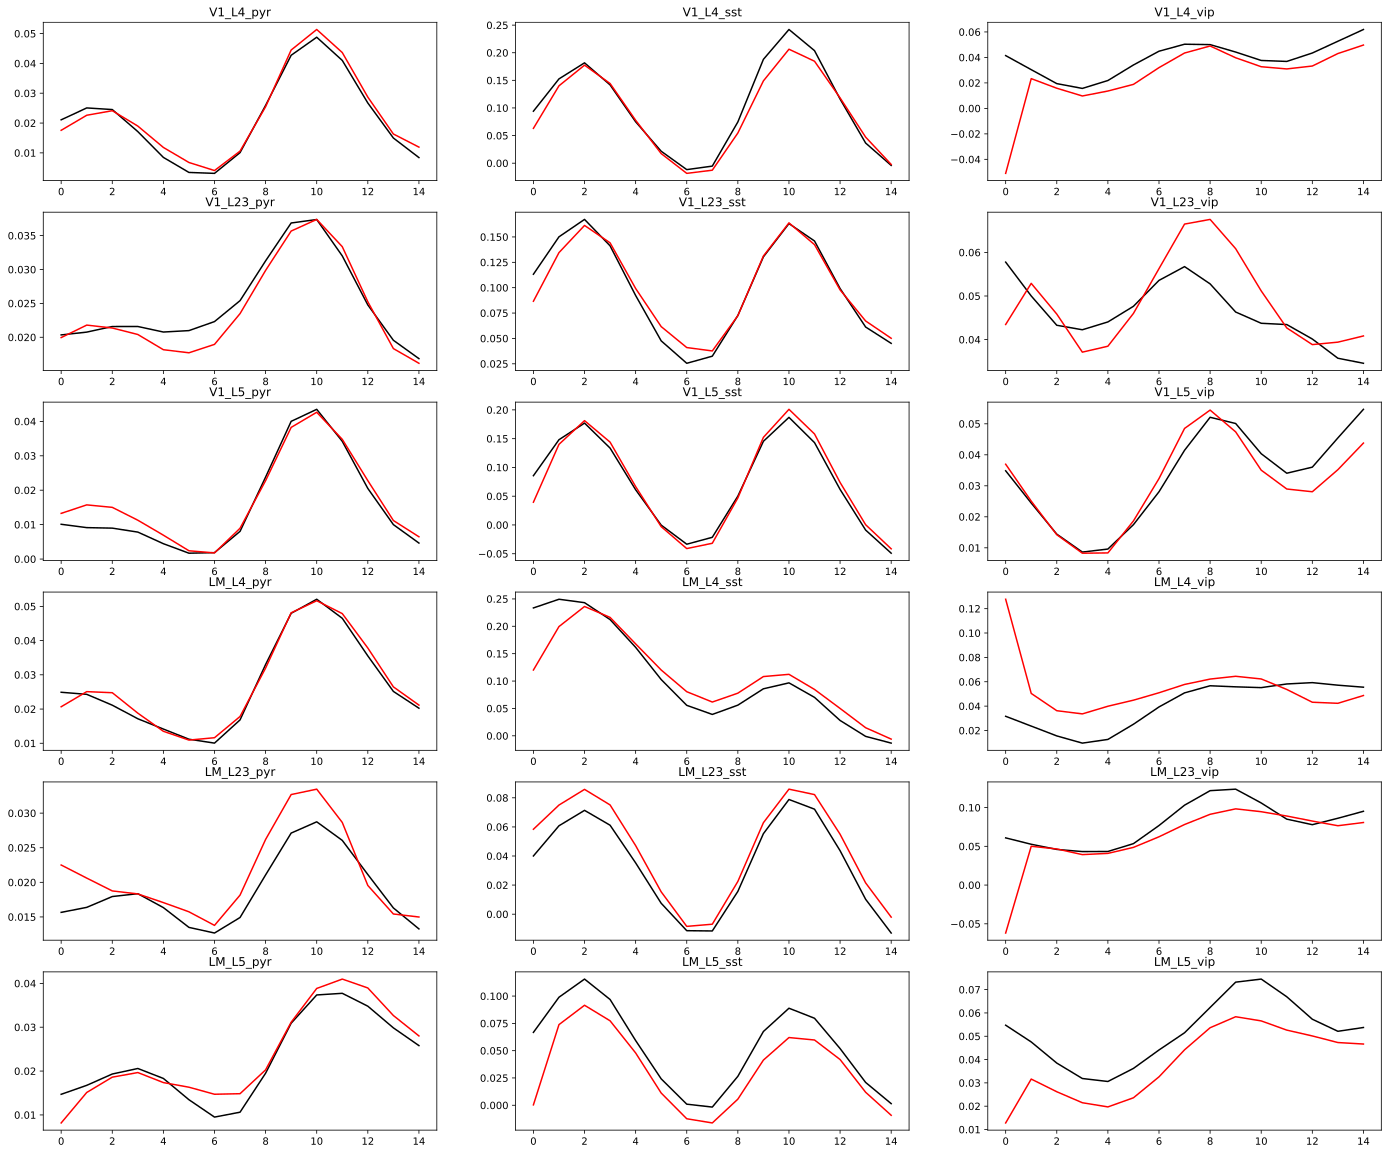

In [ ]:
ex = 10

plt.figure(figsize=(24,20))

for ii in range(n_cell_types):
    plt.subplot(6,3,ii+1)

    target_curve = targets_np[ex,:,ii]
    plt.plot(target_curve,color='k')

    output_curve = oops_np[ex,:,ii]
    plt.plot(output_curve,color='r')

    plt.title(label_arr[ii])

#### Weight analysis (post pruning)

In [ ]:
conn_mtx_final_pruned_retrained = {}
conn_mtx_pruned_init = {}

In [ ]:
for cntr in range(nRuns):
    conn_mtx_final_pruned_retrained[cntr] = (model_pruned[cntr].rnn._parameters['weight_hh_l0'].cpu().detach().numpy())
    conn_mtx_pruned_init[cntr] = conn_mtx_final_pruned[cntr]*mask_inter_areal[cntr]

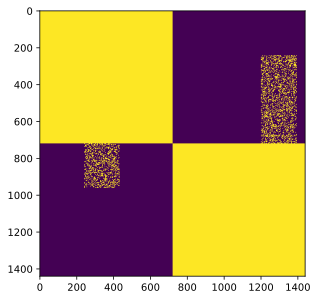

In [ ]:
MM = (mask_inter_areal[run]!=0)*1
plt.imshow(MM, interpolation='nearest')

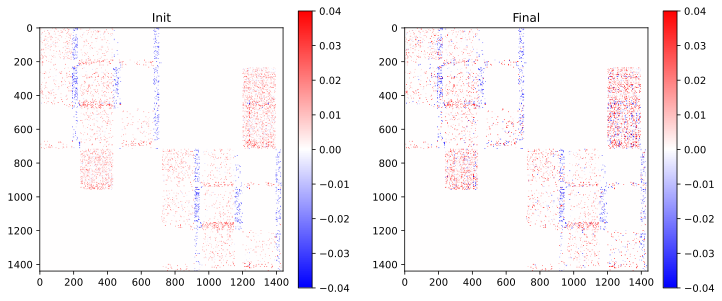

In [ ]:
run = 2

ff = plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(conn_mtx_pruned_init[run],interpolation='nearest', cmap='bwr')
plt.title("Init")
plt.colorbar()
plt.clim(-0.04,0.04)

plt.subplot(122)
plt.imshow(conn_mtx_final_pruned_retrained[run],interpolation='nearest', cmap='bwr')
plt.title("Final")
plt.colorbar()
plt.clim(-0.04,0.04)

plt.savefig(pp + 'after_pruning_vanilla_backprop.svg', format="svg", dpi=300)

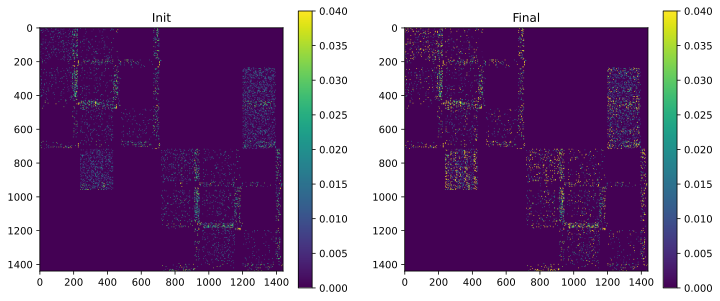

In [ ]:
run = 0

ff = plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(np.abs(conn_mtx_pruned_init[run]),interpolation='nearest')
plt.title("Init")
plt.colorbar()
plt.clim(0.0,0.04)

plt.subplot(122)
plt.imshow(np.abs(conn_mtx_final_pruned_retrained[run]),interpolation='nearest')
plt.title("Final")
plt.colorbar()
plt.clim(0.0,0.04)

In [ ]:
av_raw_init_pruned = {}
av_raw_final_pruned = {}

av_abs_init_pruned = {}
av_abs_final_pruned = {}

In [ ]:
for cntr in range(nRuns):
    av_raw_init_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices, use_absolute_values=False)
    av_raw_final_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices,
                                                           use_absolute_values=False)

    av_abs_init_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices, use_absolute_values=True)
    av_abs_final_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices,
                                                           use_absolute_values=True)

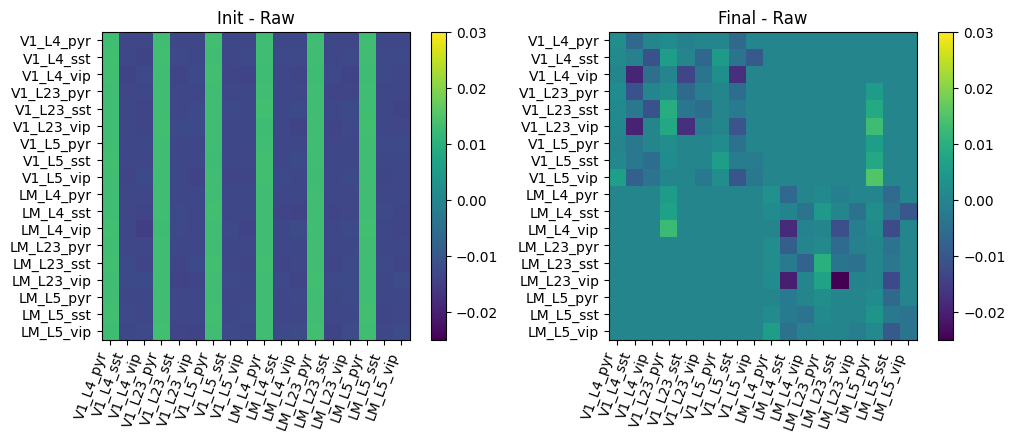

In [ ]:
fraw = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_raw_init_pruned[run], cmap='viridis', vmin=av_raw_init_pruned[run].min(), vmax=av_raw_init_pruned[run].max())
plt.title('Init - Raw')
plt.xticks(np.arange(len(label_arr)), label_arr, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr)), label_arr)
plt.colorbar()
plt.clim(-0.025,0.03)

plt.subplot(122)
plt.imshow(av_raw_final_pruned[run], cmap='viridis', vmin=av_raw_final_pruned[run].min(), vmax=av_raw_final_pruned[run].max())
plt.title('Final - Raw')
plt.xticks(np.arange(len(label_arr)), label_arr, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr)), label_arr)
plt.colorbar()
plt.clim(-0.025,0.03)

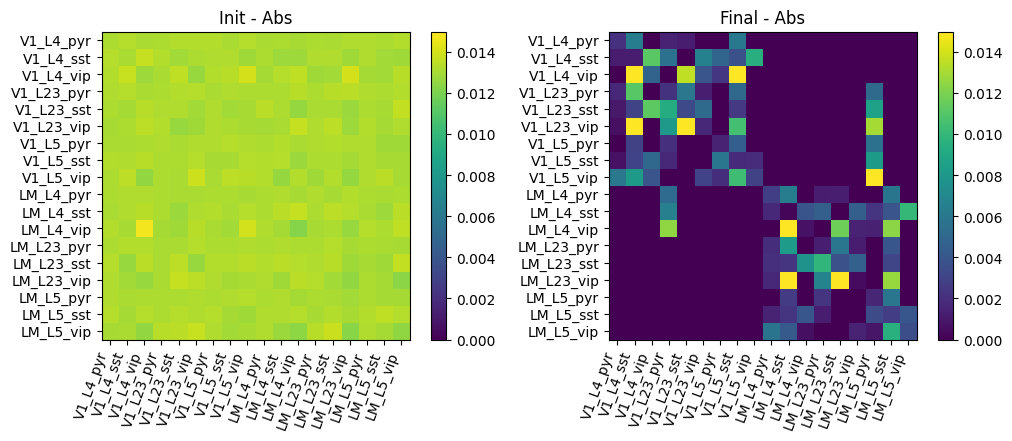

In [ ]:
fabs = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_abs_init_pruned[run], cmap='viridis', vmin=av_abs_init_pruned[run].min(), vmax=av_abs_init_pruned[run].max())
plt.title('Init - Abs')
plt.xticks(np.arange(len(label_arr)), label_arr, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr)), label_arr)
plt.colorbar()
plt.clim(0.0,0.015)

plt.subplot(122)
plt.imshow(av_abs_final_pruned[run], cmap='viridis', vmin=av_abs_final_pruned[run].min(), vmax=av_abs_final_pruned[run].max())
plt.title('Final - Abs')
plt.xticks(np.arange(len(label_arr)), label_arr, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr)), label_arr)
plt.colorbar()
plt.clim(0.0,0.015)

In [ ]:
av_raw_init_layers_pruned = {}
av_raw_final_layers_pruned = {}

av_abs_init_layers_pruned = {}
av_abs_final_layers_pruned = {}

In [ ]:
for cntr in range(nRuns):
    av_raw_init_layers_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices_layers, use_absolute_values=False)
    av_raw_final_layers_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices_layers, use_absolute_values=False)

    av_abs_init_layers_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices_layers, use_absolute_values=True)
    av_abs_final_layers_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices_layers, use_absolute_values=True)

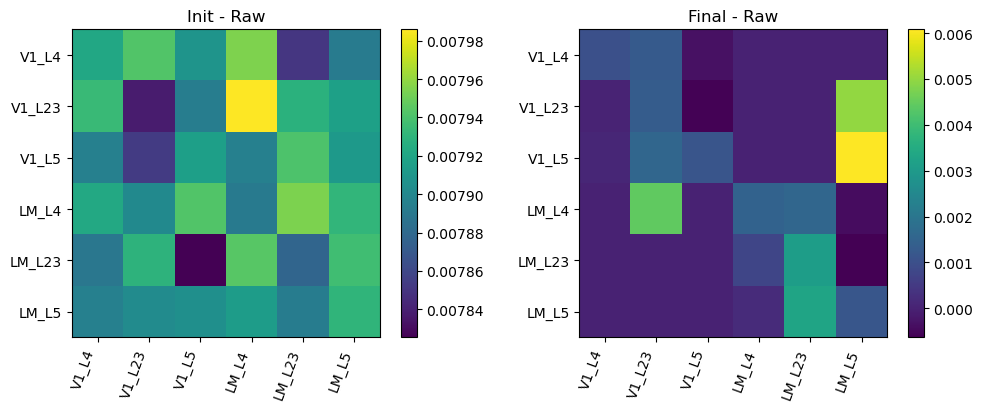

In [ ]:
fraw = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_raw_init_layers_pruned[run], cmap='viridis',
           vmin=av_raw_init_layers_pruned[run].min(), vmax=av_raw_init_layers_pruned[run].max(),interpolation='nearest')
plt.title('Init - Raw')
plt.xticks(np.arange(len(label_arr_layers)), label_arr_layers, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_layers)), label_arr_layers)
plt.colorbar()
# plt.clim(0.007,0.01)

plt.subplot(122)
plt.imshow(av_raw_final_layers_pruned[run], cmap='viridis',
           vmin=av_raw_final_layers_pruned[run].min(), vmax=av_raw_final_layers_pruned[run].max(),interpolation='nearest')
plt.title('Final - Raw')
plt.xticks(np.arange(len(label_arr_layers)), label_arr_layers, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_layers)), label_arr_layers)
plt.colorbar()
# plt.clim(0.007,0.01)

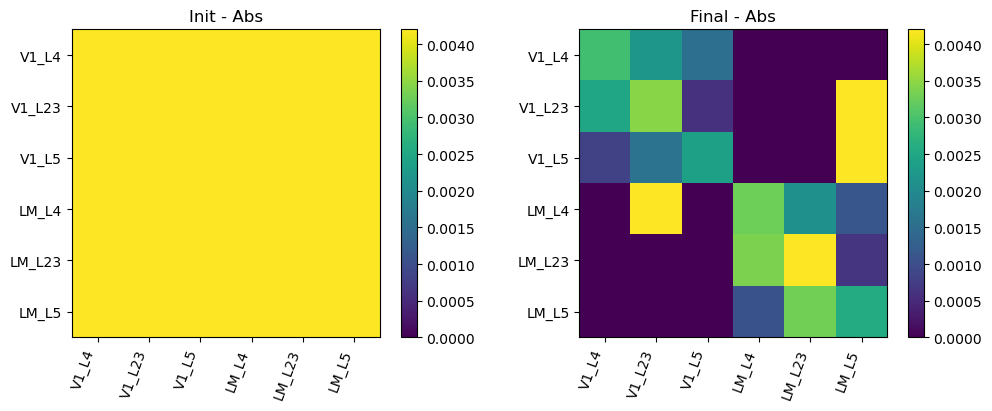

In [ ]:
fabs = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_abs_init_layers_pruned[run], cmap='viridis',
           vmin=av_abs_init_layers_pruned[run].min(), vmax=av_abs_init_layers_pruned[run].max(), interpolation='nearest')
plt.title('Init - Abs')
plt.xticks(np.arange(len(label_arr_layers)), label_arr_layers, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_layers)), label_arr_layers)
plt.colorbar()
plt.clim(0.0,0.0042)

plt.subplot(122)
plt.imshow(av_abs_final_layers_pruned[run], cmap='viridis',
           vmin=av_abs_final_layers_pruned[run].min(), vmax=av_abs_final_layers_pruned[run].max(), interpolation='nearest')
plt.title('Final - Abs')
plt.xticks(np.arange(len(label_arr_layers)), label_arr_layers, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_layers)), label_arr_layers)
plt.colorbar()
plt.clim(0.0,0.0042)

In [ ]:
av_raw_init_areas_pruned = {}
av_raw_final_areas_pruned = {}

av_abs_init_areas_pruned = {}
av_abs_final_areas_pruned = {}

In [ ]:
for cntr in range(nRuns):
    av_raw_init_areas_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices_areas, use_absolute_values=False)
    av_raw_final_areas_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices_areas, use_absolute_values=False)

    av_abs_init_areas_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices_areas, use_absolute_values=True)
    av_abs_final_areas_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices_areas, use_absolute_values=True)

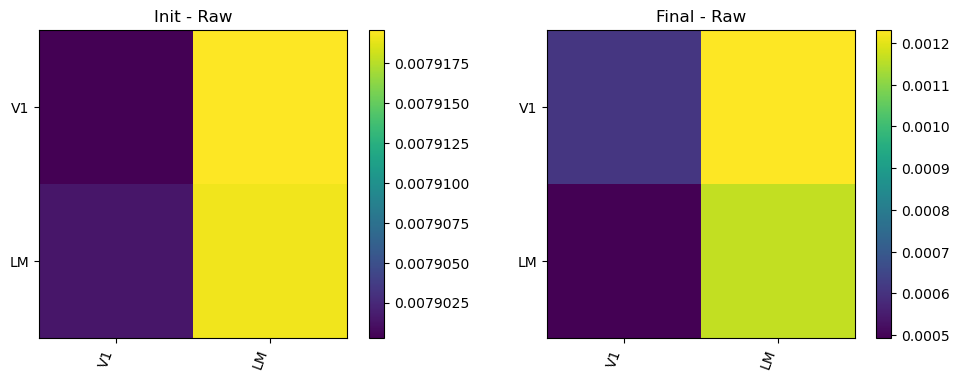

In [ ]:
fraw = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_raw_init_areas_pruned[run], cmap='viridis',
           vmin=av_raw_init_areas_pruned[run].min(), vmax=av_raw_init_areas_pruned[run].max(), interpolation='nearest')
plt.title('Init - Raw')
plt.xticks(np.arange(len(label_arr_areas)), label_arr_areas, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_areas)), label_arr_areas)
plt.colorbar()
# plt.clim(0.007,0.01)

plt.subplot(122)
plt.imshow(av_raw_final_areas_pruned[run], cmap='viridis',
           vmin=av_raw_final_areas_pruned[run].min(), vmax=av_raw_final_areas_pruned[run].max(), interpolation='nearest')
plt.title('Final - Raw')
plt.xticks(np.arange(len(label_arr_areas)), label_arr_areas, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_areas)), label_arr_areas)
plt.colorbar()
# plt.clim(0.007,0.01)

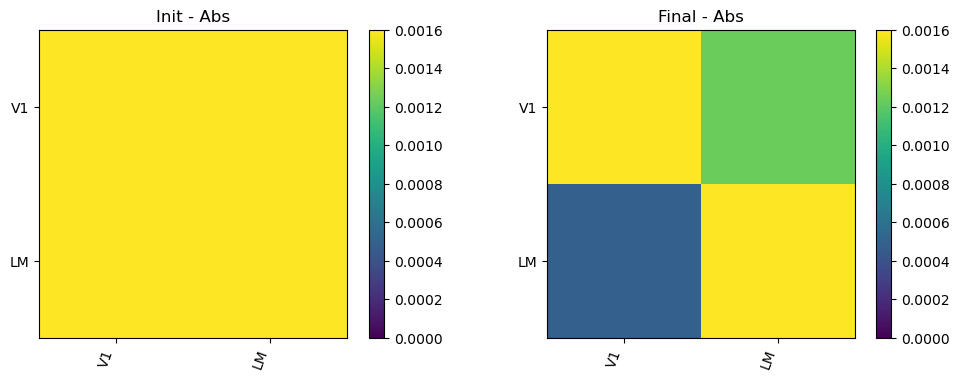

In [ ]:
fabs = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_abs_init_areas_pruned[run], cmap='viridis',
           vmin=av_abs_init_areas_pruned[run].min(), vmax=av_abs_init_areas_pruned[run].max(), interpolation='nearest')
plt.title('Init - Abs')
plt.xticks(np.arange(len(label_arr_areas)), label_arr_areas, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_areas)), label_arr_areas)
plt.colorbar()
plt.clim(0.0,0.0016)

plt.subplot(122)
plt.imshow(av_abs_final_areas_pruned[run], cmap='viridis',
           vmin=av_abs_final_areas_pruned[run].min(), vmax=av_abs_final_areas_pruned[run].max(), interpolation='nearest')
plt.title('Final - Abs')
plt.xticks(np.arange(len(label_arr_areas)), label_arr_areas, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_areas)), label_arr_areas)
plt.colorbar()
plt.clim(0.0,0.0016)

#### Scatter plot heatmap

In [ ]:
def create_scatter_heat(matrix, labels):
    # Ensure the input is a square matrix
    assert matrix.shape[0] == matrix.shape[1], "The input matrix must be square"
    assert matrix.shape[0] == len(labels), "The number of labels must match the dimensions of the matrix"

    sources, targets, values = [], [], []

    # Populate sources, targets, and values based on the matrix
    for ii in range(matrix.shape[0]):
        for jj in range(matrix.shape[1]):
            sources.append(labels[jj]+'_source')
            targets.append(labels[ii]+'_target')
            values.append(matrix[ii,jj])

    # Create a DataFrame
    data = pd.DataFrame({
        'source': sources,
        'target': targets,
        'value': values
    })

    # Create the scatterplot heatmap diagram
    # Draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=data,
        x="source", y="target", hue="value", size="value",
        palette="binary", edgecolor=".7")

    # Tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)

    return g

In [ ]:
av_pop = np.zeros((nRuns,) + av_abs_final_pruned[0].shape)
av_layers = np.zeros((nRuns,) + av_abs_final_layers_pruned[0].shape)
av_areas = np.zeros((nRuns,) + av_abs_final_areas_pruned[0].shape)

In [ ]:
for cntr in range(nRuns):
    av_pop[cntr] = av_abs_final_pruned[cntr]
    av_layers[cntr] = av_abs_final_layers_pruned[cntr]
    av_areas[cntr] = av_abs_final_areas_pruned[cntr]

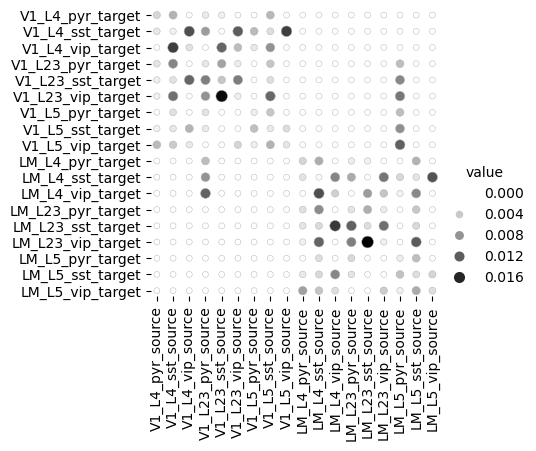

In [ ]:
g_pop = create_scatter_heat(np.mean(av_pop,0), label_arr)

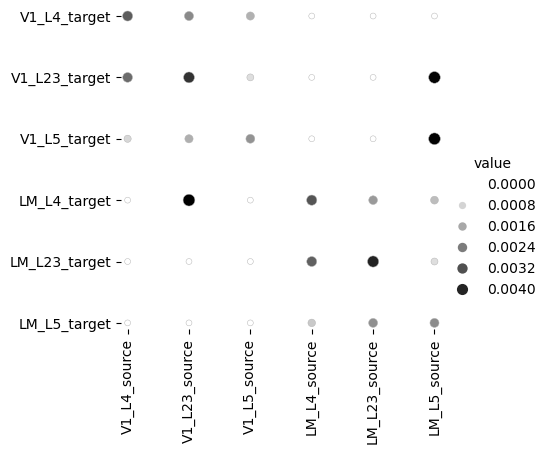

In [ ]:
g_layers = create_scatter_heat(np.mean(av_layers,0), label_arr_layers)

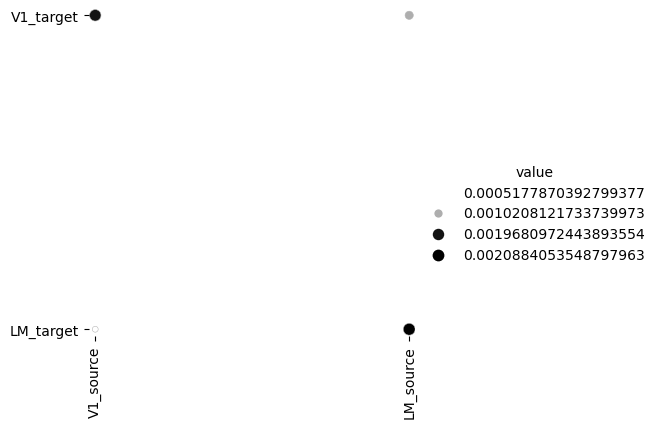

In [ ]:
g_areas = create_scatter_heat(np.mean(av_areas,0), label_arr_areas)

#### Scatter plot heatmap : Node size = normalized active connection strength

In [ ]:
def create_normalized_scatter_heat(matrix, labels, av_mask):
    # Ensure the input is a square matrix
    assert matrix.shape[0] == matrix.shape[1], "The input matrix must be square"
    assert matrix.shape[0] == len(labels), "The number of labels must match the dimensions of the matrix"
    assert matrix.shape == av_mask.shape, "The input matrix and connection probabilities  must be of same size"

    sources, targets, values, probs = [], [], [], []

    # Populate sources, targets, and values based on the matrix
    for ii in range(matrix.shape[0]):
        for jj in range(matrix.shape[1]):
            sources.append(labels[jj]+'_source')
            targets.append(labels[ii]+'_target')
            values.append(matrix[ii,jj])
            probs.append(av_mask[ii,jj])

    # Create a DataFrame
    data = pd.DataFrame({
        'source': sources,
        'target': targets,
        'value': values,
        'probs': probs
    })

    # Create the scatterplot heatmap diagram
    # Draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=data,
        x="source", y="target", hue="value", size="probs",
        palette="binary", edgecolor=".7")

    # Tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)

    return g

In [ ]:
av_mask_pop = {}
av_mask_layers = {}
av_mask_areas = {}

In [ ]:
for cntr in range(nRuns):
    av_mask_pop[cntr] = average_weights_in_blocks_matrix((np.abs(conn_mtx_final_pruned_retrained[cntr])>0)*1, block_indices)
    av_mask_layers[cntr] = average_weights_in_blocks_matrix((np.abs(conn_mtx_final_pruned_retrained[cntr])>0)*1, block_indices_layers)
    av_mask_areas[cntr] = average_weights_in_blocks_matrix((np.abs(conn_mtx_final_pruned_retrained[cntr])>0)*1, block_indices_areas)

In [ ]:
av_mask_pop = np.zeros((nRuns,) + av_mask_pop[0].shape)
av_mask_layers = np.zeros((nRuns,) + av_mask_layers[0].shape)
av_mask_areas = np.zeros((nRuns,) + av_mask_areas[0].shape)

In [ ]:
for cntr in range(nRuns):
    av_mask_pop[cntr] = av_mask_pop[cntr]
    av_mask_layers[cntr] = av_mask_layers[cntr]
    av_mask_areas[cntr] = av_mask_areas[cntr]

In [ ]:
ng_pop = {}
ng_layers = {}
ng_areas = {}

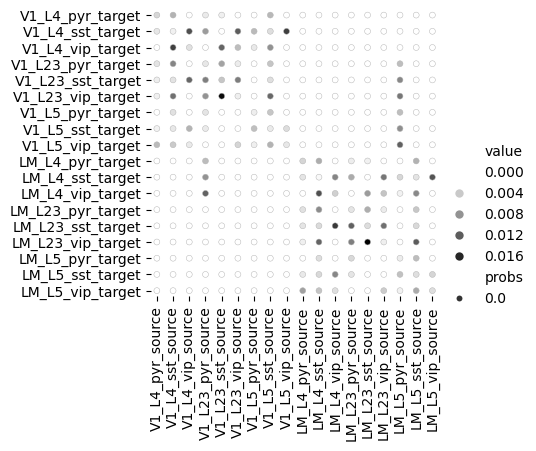

In [ ]:
ng_pop = create_normalized_scatter_heat(np.mean(av_pop,0), label_arr, np.mean(av_mask_pop,0))

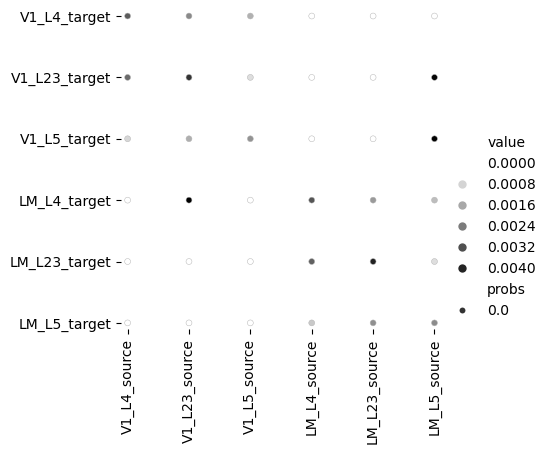

In [ ]:
ng_layers = create_normalized_scatter_heat(np.mean(av_layers,0), label_arr_layers, np.mean(av_mask_layers,0))

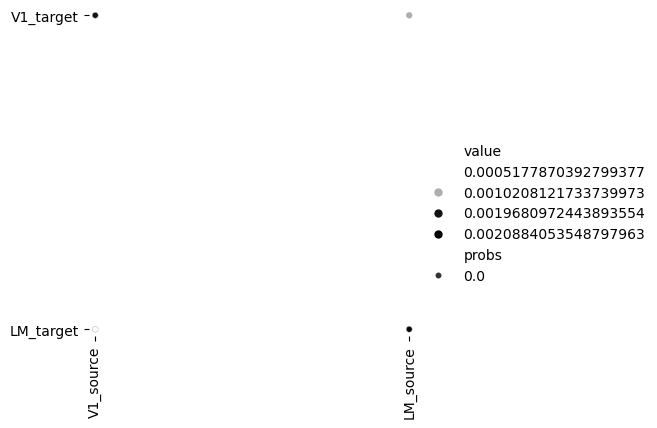

In [ ]:
ng_areas = create_normalized_scatter_heat(np.mean(av_areas,0), label_arr_areas, np.mean(av_mask_areas,0))

#### Scatter plot with dispersion and significance

In [ ]:
def calculate_dispersion_and_significance(data, dispersion_type):
    """
    Calculate dispersion for each element across multiple runs and their significance.

    Parameters:
    - data: numpy array of shape (nRuns, val1, val2)
    - dispersion_type: str, one of ['std', 'var', 'range', 'iqr', 'cv']

    Returns:
    - dispersion: numpy array of shape (val1, val2)
    - significance: numpy array of p-values with shape (val1, val2)
    """

    # Check if input data is a numpy array
    if not isinstance(data, np.ndarray):
        raise ValueError("Data should be a numpy array")

    # Check if the dispersion_type is valid
    valid_types = ['std', 'var', 'range', 'iqr', 'cv']
    if dispersion_type not in valid_types:
        raise ValueError(f"Dispersion type should be one of {valid_types}")

    # Initialize the output arrays
    val1, val2 = data.shape[1], data.shape[2]
    dispersion = np.zeros((val1, val2))
    significance = np.zeros((val1, val2))

    for ii in range(val1):
        for jj in range(val2):
            values = data[:, ii, jj]
            if dispersion_type == 'std':
                dispersion[ii, jj] = np.std(values)
            elif dispersion_type == 'var':
                dispersion[ii, jj] = np.var(values)
            elif dispersion_type == 'range':
                dispersion[ii, jj] = np.ptp(values)
            elif dispersion_type == 'iqr':
                dispersion[ii, jj] = np.percentile(values, 75) - np.percentile(values, 25)
            elif dispersion_type == 'cv':
                dispersion[ii, jj] = 1-np.std(values) / np.mean(values)

            # Perform t-test for significance
            t_stat, p_value = ttest_ind(values, values)
            significance[ii, jj] = p_value

    return dispersion, significance

In [ ]:
dispersion_type = 'cv'
disp_pop, sig_pop = calculate_dispersion_and_significance(av_pop, dispersion_type)
disp_layers, sig_layers = calculate_dispersion_and_significance(av_layers, dispersion_type)
disp_areas, sig_areas = calculate_dispersion_and_significance(av_areas, dispersion_type)

/tmp/ipykernel_1156180/2317318918.py:40: RuntimeWarning: invalid value encountered in double_scalars
  dispersion[ii, jj] = 1-np.std(values) / np.mean(values)


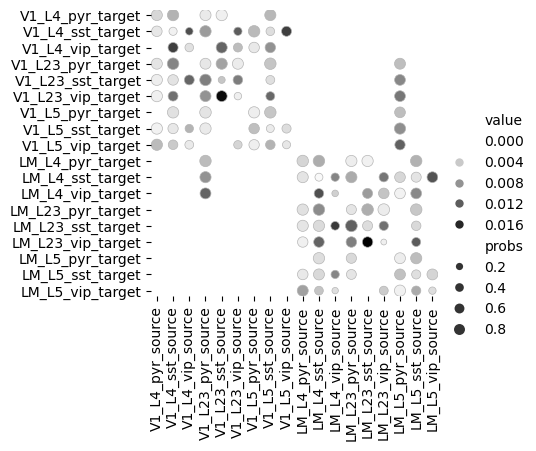

In [ ]:
ng_pop = create_normalized_scatter_heat(np.mean(av_pop,0), label_arr, disp_pop)

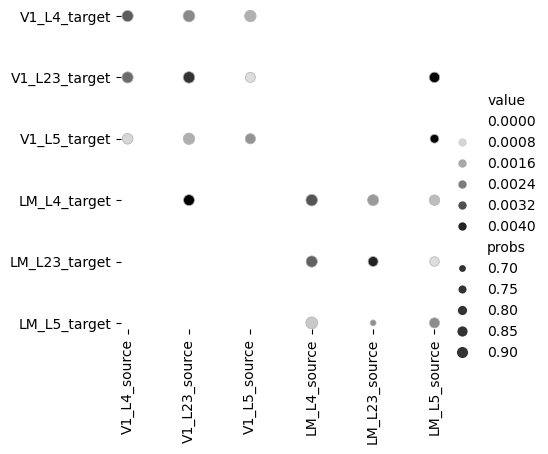

In [ ]:
ng_layers = create_normalized_scatter_heat(np.mean(av_layers,0), label_arr_layers, disp_layers)

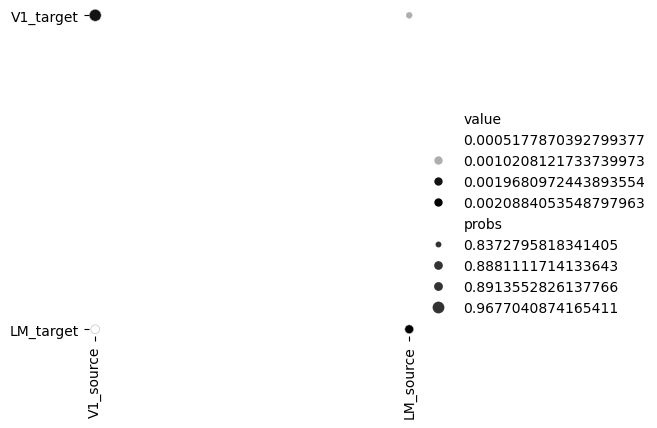

In [ ]:
ng_areas = create_normalized_scatter_heat(np.mean(av_areas,0), label_arr_areas, disp_areas)